# MYD climatologies

This script calculated the MYD climatologies for every focus region

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
from xclim.indices import standardized_precipitation_evapotranspiration_index
import spei as si  # si for standardized index 
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy import stats
import matplotlib.ticker as mticker
import colormaps as cmaps
from IPython.display import HTML

Open the SPEI-12, standardized EVI anomaly and landcover data

In [2]:
SPEI_grid = xr.open_dataset("/scratch/ruiij001/Data/SPEI/0_1_degrees_apr_2024/Compessed/SPEI12_monthly_2000_2023_0_1_degree.nc").__xarray_dataarray_variable__.sel(time=slice("2000-02", "2022-12")) #new spei with 2023 and 1955-2020 calibration
EVI_st_an = xr.open_dataset("/scratch/ruiij001/Data/EVI/EVI_st_an_2000_2022_0_1_degree.nc").EVI.sel(time=slice("2000-02", "2022-12"))
lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/newest/regrid/ESACCI-LC-L4-LCCS-Map-0_1_degrees_regrid-P1Y-2000_2015-v2.0.7cds_and_C3S-LC-L4-LCCS-Map-0_1_degrees-P1Y-2016_2022-v2.1.1_regridded.nc").lccs_class.sel(time=slice("2000-02", "2022-12"))

Definition that calculates the standardized EVI anomaly in the year before, the first and second year of the MYDs. 

In [3]:
def MYD_EVI_yearbefore_first_second(region_name, months, year):
    if region_name == "IND": 
        reg_lat = slice(22, 32)
        reg_lon = slice(72, 90)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "BAH":
        reg_lat = slice(19,37) 
        reg_lon = slice(81,99)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "AUS":
        reg_lat = slice(-40, -20)
        reg_lon = slice(135, 155)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "WEU":
        reg_lat = slice(45, 55)
        reg_lon = slice(-1, 13)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "SA":
        reg_lat = slice(-33, -21)
        reg_lon = slice(15, 31)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "ARG":
        reg_lat = slice(-58, -18)
        reg_lon = slice(-80, -50)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "CAL":
        reg_lat = slice(30, 43)
        reg_lon = slice(-126, -113)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
        
    #slice the data based on the region
    spei_region = SPEI_grid.sel(lat=reg_lat, lon=reg_lon).where(region_mask == 1)
    EVI_region_an = EVI_st_an.sel(lat=reg_lat, lon=reg_lon).where(region_mask == 1)
    
    #--------------------------------------MYD------------------------------------
    # Create a mask where SPEI_AUS_grid is less than or equal to -1
    mask = spei_region <= -1

    # Apply a rolling window of size 12 along the time dimension and check where the sum is 12
    rolling_sum = mask.rolling(time=12).sum()

    # Create a new mask where rolling_sum is greater than or equal to 12
    final_mask = rolling_sum >= 12

    data_array_np = final_mask.values


    if year == 0:
        # Iterate over each latitude and longitude
        for lat in range(data_array_np.shape[1]):
            for lon in range(data_array_np.shape[2]):
                # Iterate over each time step
                consecutive_true_count = 0
                for t in range(data_array_np.shape[0]):
                    # Check if the current value is True
                    if data_array_np[t, lat, lon]:
                        consecutive_true_count += 1
                        if consecutive_true_count > 1:
                        # Set the current value to False
                            data_array_np[t, lat, lon] = False
                    else:
                        # Reset the consecutive True count if the current value is False
                        consecutive_true_count = 0
                        
        # Iterate over each latitude and longitude
        for lat in range(data_array_np.shape[1]):
            for lon in range(data_array_np.shape[2]):
                for t in range(data_array_np.shape[0]):
                    # Check if the current value is True
                    if data_array_np[t, lat, lon]:
                        # Set the current true value to flase
                        data_array_np[t, lat, lon] = False
                        # Set the 24-12 values before the True value to True
                        data_array_np[(t-23):(t-months), lat, lon] = True
    
    if year == 1:
        # Iterate over each latitude and longitude
        for lat in range(data_array_np.shape[1]):
            for lon in range(data_array_np.shape[2]):
                # Iterate over each time step
                consecutive_true_count = 0
                for t in range(data_array_np.shape[0]):
                    # Check if the current value is True
                    if data_array_np[t, lat, lon]:
                        consecutive_true_count += 1
                        if consecutive_true_count > 1:
                        # Set the current value to False
                            data_array_np[t, lat, lon] = False
                    else:
                        # Reset the consecutive True count if the current value is False
                        consecutive_true_count = 0
                        
        # Iterate over each latitude and longitude
        for lat in range(data_array_np.shape[1]):
            for lon in range(data_array_np.shape[2]):
                for t in range(data_array_np.shape[0]):
                    # Check if the current value is True
                    if data_array_np[t, lat, lon]:
                        # Set the 12 values before the True value to True
                        data_array_np[(t-months):t, lat, lon] = True          
    
    #you have the second year automatically when doing the rolling thing. 
                  
    # Convert the modified numpy array back to a DataArray
    modified_data_array = xr.DataArray(data_array_np, coords=final_mask.coords, dims=final_mask.dims)

    # Convert the DataArray to a numpy array
    data_array_np = modified_data_array.values

    # Create a new array with 1 for True values and nan for False values
    new_mask_array = np.where(data_array_np, 1, np.nan)

    # Convert the new array back to a DataArray
    new_mask_data_array = xr.DataArray(new_mask_array, coords=final_mask.coords, dims=final_mask.dims)
    
    SPEI_region_grid_MYD = spei_region.where(new_mask_data_array==1)
    EVI_region_grid_an_MYD = EVI_region_an.where(new_mask_data_array==1)
    
    #--------------------------------------ND----------------------------------------------------------------------
    #for normal droughts
    condition_d = (spei_region<=-1) & (new_mask_data_array!=1)
    SPEI_region_grid_nd = spei_region.where(condition_d)
    EVI_region_grid_an_nd = EVI_region_an.where(condition_d)
    
    return EVI_region_an, EVI_region_grid_an_MYD, EVI_region_grid_an_nd, spei_region, SPEI_region_grid_MYD, SPEI_region_grid_nd


Definition that calculates the starting month of each MYD. The starting month is needed because the climatology needs a starting month. 

In [4]:
def MYD_EVI_starting_month(region_name):
    if region_name == "IND": #IND, AUS, WEU, SA, SSA, CAL
        reg_lat = slice(22, 32)
        reg_lon = slice(72, 90)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "BAH":
        reg_lat = slice(19,37) 
        reg_lon = slice(81,99)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "AUS":
        reg_lat = slice(-40, -20)
        reg_lon = slice(135, 155)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "WEU":
        reg_lat = slice(45, 55)
        reg_lon = slice(-1, 13)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "SA":
        reg_lat = slice(-33, -21)
        reg_lon = slice(15, 31)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "ARG":
        reg_lat = slice(-58, -18)
        reg_lon = slice(-80, -50)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "CAL":
        reg_lat = slice(30, 43)
        reg_lon = slice(-126, -113)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
        
    #slice the data based on the region
    spei_region = SPEI_grid.sel(lat=reg_lat, lon=reg_lon).where(region_mask == 1)
    EVI_region_an = EVI_st_an.sel(lat=reg_lat, lon=reg_lon).where(region_mask == 1)
    
    #--------------------------------------MYD------------------------------------
    # Create a mask where SPEI_AUS_grid is less than or equal to -1
    mask = spei_region <= -1

    # Apply a rolling window of size 12 along the time dimension and check where the sum is 12
    rolling_sum = mask.rolling(time=12).sum()

    # Create a new mask where rolling_sum is greater than or equal to 12
    final_mask = rolling_sum >= 12

    # Convert the DataArray to a numpy array
    data_array = final_mask
    data_array_np = data_array.values

    for lat in range(data_array_np.shape[1]):
        for lon in range(data_array_np.shape[2]):
            # Iterate over each time step
            consecutive_true_count = 0
            for t in range(data_array_np.shape[0]):
                # Check if the current value is True
                if data_array_np[t, lat, lon]:
                    consecutive_true_count += 1
                    if consecutive_true_count > 1:
                    # Set the current value to False
                        data_array_np[t, lat, lon] = False
                else:
                    # Reset the consecutive True count if the current value is False
                    consecutive_true_count = 0
                    
    for lat in range(data_array_np.shape[1]):
        for lon in range(data_array_np.shape[2]):
            for t in range(data_array_np.shape[0]):
                # Check if the current value is True
                if data_array_np[t, lat, lon]:
                    data_array_np[t-11, lat, lon] = True
                    data_array_np[t, lat, lon] = False
          

    # Convert the modified numpy array back to a DataArray
    modified_data_array = xr.DataArray(data_array_np, coords=data_array.coords, dims=data_array.dims)

    # Convert the DataArray to a numpy array
    data_array_np = modified_data_array.values

    # Create a new array with 1 for True values and nan for False values
    new_mask_array = np.where(data_array_np, 1, np.nan)

    # Convert the new array back to a DataArray
    new_mask_data_array = xr.DataArray(new_mask_array, coords=data_array.coords, dims=data_array.dims)
    
    SPEI_region_grid_MYD = spei_region.where(new_mask_data_array==1)
    EVI_region_grid_an_MYD = EVI_region_an.where(new_mask_data_array==1)    
        
    #--------------------------------------ND----------------------------------------------------------------------
    #for normal droughts
    condition_d = (spei_region<=-1) & (new_mask_data_array!=1)
    SPEI_region_grid_nd = spei_region.where(condition_d)
    EVI_region_grid_an_nd = EVI_region_an.where(condition_d)
    
    return EVI_region_an, EVI_region_grid_an_MYD, EVI_region_grid_an_nd, spei_region, SPEI_region_grid_MYD, SPEI_region_grid_nd


In [5]:
def starting_month_plot(EVI_region_grid_an_MYD, landcover):
    # Define the types, titles, and colors
    cropland_rainfed = np.arange(9, 13)
    cropland_irrigated = np.arange(19, 21)
    broadleaved = np.arange(49, 63)
    needleleaved = np.arange(69, 83)
    shrubland = np.arange(119, 123)
    grassland = np.arange(129, 131)
    urban = np.arange(189, 191)

    types = [cropland_rainfed, cropland_irrigated, broadleaved, needleleaved, shrubland, grassland, urban]
    titles = ["Cropland, rainfed", "Cropland, irrigated", "Tree cover, broadleaved", "Tree cover, needleleaved", "Shrubland", "Grassland", "Urban areas"]
        
    colors = ['#FFD700', '#32CD32', '#8B008B', '#FFA500', '#00BFFF', '#FF69B4', '#708090']
    color_dict = dict(zip(titles, colors))  # Map titles to colors

    plt.figure(figsize=(16, 9))
    legend_labels = []
    for type_, title in zip(types, titles):
            print(type_, title)
            MYD_res_type = EVI_region_grid_an_MYD.where(landcover.isin(type_))
            a = MYD_res_type.groupby('time.month').count().sum(dim = ["lon","lat"])
            months = ["Jan","Feb","Maa","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
            plt.plot(months,a, color = color_dict[title],linewidth=1.8, label=title, marker = 'o')
            legend_labels.append(title)
            
    custom_legend = [plt.Line2D([0], [0], color=color_dict[label], lw=2) for label in legend_labels]
    plt.legend(custom_legend, legend_labels)

In [6]:
def starting_month_plot_normalized(EVI_region_grid_an_MYD, landcover):
    # Define the types, titles, and colors
    cropland_rainfed = np.arange(9, 13)
    cropland_irrigated = np.arange(19, 21)
    broadleaved = np.arange(49, 63)
    needleleaved = np.arange(69, 83)
    shrubland = np.arange(119, 123)
    grassland = np.arange(129, 131)
    urban = np.arange(189, 191)

    types = [cropland_rainfed, cropland_irrigated, broadleaved, needleleaved, shrubland, grassland, urban]
    titles = ["Cropland, rainfed", "Cropland, irrigated", "Tree cover, broadleaved", "Tree cover, needleleaved", "Shrubland", "Grassland", "Urban areas"]
        
    colors = ['#FFD700', '#32CD32', '#8B008B', '#FFA500', '#00BFFF', '#FF69B4', '#708090']
    color_dict = dict(zip(titles, colors))  # Map titles to colors

    plt.figure(figsize=(16, 9))
    legend_labels = []
    for type_, title in zip(types, titles):
            MYD_res_type = EVI_region_grid_an_MYD.where(landcover.isin(type_))
            a = MYD_res_type.groupby('time.month').count().sum(dim = ["lon","lat"])
            total_count = a.sum()  # Total count for this land cover type
            months = ["Jan","Feb","Maa","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
            plt.plot(months, a/total_count, color=color_dict[title], linewidth=1.8, label=title, marker='o')  # Normalize the counts
            legend_labels.append(title)
            
    custom_legend = [plt.Line2D([0], [0], color=color_dict[label], lw=2) for label in legend_labels]
    plt.legend(custom_legend, legend_labels)
    plt.ylim(-0.01, 0.47)  # Set y-axis limit from 0 to 1

# Example usage:
# starting_month_plot(EVI_region_grid_an_MYD, landcover)


Count the number of grid cells for each landcover. If there are not enough grid cells, the landcover is not taken into account. 

In [7]:
def count_grid_cells_by_landcover(EVI_data, landcover_data, landcover_types):
    """
    Count the number of grid cells for each landcover type in the EVI data.

    Parameters:
    - EVI_data (xarray.DataArray): DataArray containing EVI values.
    - landcover_data (xarray.DataArray): DataArray containing landcover data.
    - landcover_types (dict): Dictionary mapping landcover types to value ranges.

    Returns:
    - counts (dict): Dictionary containing the counts of grid cells for each landcover type.
    """

    counts = {}

    for landcover, (values, _) in landcover_types.items():
        masked_data = EVI_data.where(landcover_data.isin(values))
        counts[landcover] = int(masked_data.count().values)

    return counts

If a starting month is chosen, only the MYDs starting in that month should be considered for the climatology

In [8]:
import copy
def filter_starting_month(data_array, starting_month):
    data_array_np = data_array.values
    # Iterate over each latitude and longitude
    for lat in range(data_array_np.shape[1]):
        for lon in range(data_array_np.shape[2]):
            nan_indices = []
            for t in range(data_array_np.shape[0]-1):
                # Check if the current value is True
                if np.isnan(data_array_np[t,lat,lon]) and not np.isnan(data_array_np[t + 1,lat,lon]):
                    nan_indices.append(t)
            for idx in nan_indices:
                if data_array[idx,lat,lon].time.dt.month not in starting_month:
                    data_array_np[idx:idx+13,lat,lon] = np.nan
                    
    new_mask_array = np.where(data_array_np, 1, np.nan)
    new_mask_data_array = xr.DataArray(new_mask_array, coords=data_array.coords, dims=data_array.dims)
    data_array_new = data_array.where(new_mask_data_array==1)
    
    return data_array_new


## Plotting

In [9]:
def line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig=False):
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    landcover_types = {
        'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
        'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
        'broadleaved': (np.arange(49, 63), '#8B008B'),
        'needleleaved': (np.arange(69, 83), '#FFA500'),
        'shrubland': (np.arange(119, 123), '#00BFFF'),
        'grassland': (np.arange(129, 131), '#FF69B4'),
        'urban': (np.arange(189, 191), '#708090')
    }
    
    # Filter included landcover types
    types = [landcover_types[landcover_type][0] for landcover_type in included_landcovers]
    titles = [landcover_type.replace("_", " ").title() for landcover_type in included_landcovers]  # Convert to title case
    colors = [landcover_types[landcover_type][1] for landcover_type in included_landcovers]

    
    plt.figure(figsize=(16, 9))
    legend_labels = []  # To store legend labels with valid data
    color_labels = []
    
    for i, (type, title, color) in enumerate(zip(types, titles, colors)):
        
        #take the mean over lon and lat before standardizing
        mean_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median(dim=['time','lon','lat']).roll(month=-starting_month+1)
        mean_data_standardized_before['month'] = xr.concat([mean_data_standardized_before['month'][starting_month-1:], mean_data_standardized_before['month'][:starting_month-1]], dim='month')
        mean_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median(dim=['time','lon','lat']).roll(month=-starting_month+1)
        mean_data_standardized_year1['month'] = xr.concat([mean_data_standardized_year1['month'][starting_month-1:], mean_data_standardized_year1['month'][:starting_month-1]], dim='month')
        mean_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median(dim=['time','lon','lat']).roll(month=-starting_month+1)
        mean_data_standardized_year2['month'] = xr.concat([mean_data_standardized_year2['month'][starting_month-1:], mean_data_standardized_year2['month'][:starting_month-1]], dim='month')
        
        mean_data_standardized = xr.concat([mean_data_standardized_before,mean_data_standardized_year1,mean_data_standardized_year2], dim = "month")
        
        # Check if there is any valid data to plot
        if not np.isnan(mean_data_standardized).all():
            
            #take the mean over lon and lat before standardizing
            percent_25_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_25_data_standardized_before['month'] = xr.concat([percent_25_data_standardized_before['month'][starting_month-1:], percent_25_data_standardized_before['month'][:starting_month-1]], dim='month')
            percent_25_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_25_data_standardized_year1['month'] = xr.concat([percent_25_data_standardized_year1['month'][starting_month-1:], percent_25_data_standardized_year1['month'][:starting_month-1]], dim='month')
            percent_25_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_25_data_standardized_year2['month'] = xr.concat([percent_25_data_standardized_year2['month'][starting_month-1:], percent_25_data_standardized_year2['month'][:starting_month-1]], dim='month')
            
            percent_25_data_standardized = xr.concat([percent_25_data_standardized_before,percent_25_data_standardized_year1,percent_25_data_standardized_year2], dim = "month")
            
            percent_75_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_75_data_standardized_before['month'] = xr.concat([percent_75_data_standardized_before['month'][starting_month-1:], percent_75_data_standardized_before['month'][:starting_month-1]], dim='month')
            percent_75_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_75_data_standardized_year1['month'] = xr.concat([percent_75_data_standardized_year1['month'][starting_month-1:], percent_75_data_standardized_year1['month'][:starting_month-1]], dim='month')
            percent_75_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon','lat']).roll(month=-starting_month+1)
            percent_75_data_standardized_year2['month'] = xr.concat([percent_75_data_standardized_year2['month'][starting_month-1:], percent_75_data_standardized_year2['month'][:starting_month-1]], dim='month')

            percent_75_data_standardized = xr.concat([percent_75_data_standardized_before, percent_75_data_standardized_year1, percent_75_data_standardized_year2], dim="month")

            # Plot data
            color = color  # Get color from dictionary
            plt.plot(np.arange(1,len(mean_data_standardized)), mean_data_standardized[1:], linewidth=1.8, color=color, label=title, marker = 'o')
            
            if shade == True:
                plt.fill_between(np.arange(1,len(mean_data_standardized)), percent_25_data_standardized[1:], percent_75_data_standardized[1:], color=color, alpha=0.2)

            legend_labels.append(title)  # Add title to legend if there is valid data
            color_labels.append(color)
   
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.9)
    plt.axvline(x=np.array(np.arange(len(mean_data_standardized))[11]+0.5), color='black', linestyle='--', linewidth=0.9)
    plt.title(suptitle)
    plt.ylim([ymin, ymax])
    plt.grid(True)
    # Add custom legend with consistent colors
    custom_legend = [plt.Line2D([0], [0], color=color_labels[i], lw=2) for i,label in enumerate(legend_labels)]
    plt.legend(custom_legend, legend_labels)
    ticks_positions = np.arange(len(months))
    shifted_months = months[starting_month-1:] + months[:starting_month-1]
    plt.xticks(ticks_positions[1:], shifted_months[1:])
    if savefig == True:
        plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/drought_climatology_MYDs_2000_2022_"+region_name+"_filtered.png",dpi = 600, bbox_inches = "tight")
    plt.show()
    
    return mean_data_standardized



In [10]:
def line_moreyears_some_one_figure(region_names, suptitle, EVI_region_lc_MYDs_list, starting_months, landcovers, included_landcovers_list, ymin, ymax, ylabel, shade, savefig=False):
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
              "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
              "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    landcover_types = {
        'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
        'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
        'broadleaved': (np.arange(49, 63), '#8B008B'),
        'needleleaved': (np.arange(69, 83), '#FFA500'),
        'shrubland': (np.arange(119, 123), '#00BFFF'),
        'grassland': (np.arange(129, 131), '#FF69B4'),
        'urban': (np.arange(189, 191), '#708090')
    }
    titles_short = ["CR", "CI", "TB", "TN", "SR", "GR", "UR"]
    colors = ['#FFD700', '#32CD32', '#8B008B', '#FFA500', '#00BFFF', '#FF69B4', '#708090']

    num_subplots = len(EVI_region_lc_MYDs_list)
    fig, axes = plt.subplots(1, num_subplots, figsize=(16 * num_subplots, 12), sharey=True)

    if num_subplots == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one subplot

    all_legend_labels = []
    all_color_labels = []

    for idx, ((EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2), starting_month, landcover, included_landcovers, region_names) in enumerate(zip(EVI_region_lc_MYDs_list, starting_months, landcovers, included_landcovers_list, region_names)):
        ax = axes[idx]
        
        # Filter included landcover types for this region
        types = [landcover_types[landcover_type][0] for landcover_type in included_landcovers]
        titles = [landcover_type.replace("_", " ").title() for landcover_type in included_landcovers]
        colors = [landcover_types[landcover_type][1] for landcover_type in included_landcovers]
        
        for type, title, color in zip(types, titles, colors):
            mean_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median(dim=['time', 'lon', 'lat']).roll(month=-starting_month+1)
            mean_data_standardized_before['month'] = xr.concat([mean_data_standardized_before['month'][starting_month-1:], mean_data_standardized_before['month'][:starting_month-1]], dim='month')
            mean_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median(dim=['time', 'lon', 'lat']).roll(month=-starting_month+1)
            mean_data_standardized_year1['month'] = xr.concat([mean_data_standardized_year1['month'][starting_month-1:], mean_data_standardized_year1['month'][:starting_month-1]], dim='month')
            mean_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median(dim=['time', 'lon', 'lat']).roll(month=-starting_month+1)
            mean_data_standardized_year2['month'] = xr.concat([mean_data_standardized_year2['month'][starting_month-1:], mean_data_standardized_year2['month'][:starting_month-1]], dim='month')

            mean_data_standardized = xr.concat([mean_data_standardized_before, mean_data_standardized_year1, mean_data_standardized_year2], dim='month')

            # Check if there is any valid data to plot
            if not np.isnan(mean_data_standardized).all():
                percent_25_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_25_data_standardized_before['month'] = xr.concat([percent_25_data_standardized_before['month'][starting_month-1:], percent_25_data_standardized_before['month'][:starting_month-1]], dim='month')
                percent_25_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_25_data_standardized_year1['month'] = xr.concat([percent_25_data_standardized_year1['month'][starting_month-1:], percent_25_data_standardized_year1['month'][:starting_month-1]], dim='month')
                percent_25_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.25, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_25_data_standardized_year2['month'] = xr.concat([percent_25_data_standardized_year2['month'][starting_month-1:], percent_25_data_standardized_year2['month'][:starting_month-1]], dim='month')

                percent_25_data_standardized = xr.concat([percent_25_data_standardized_before, percent_25_data_standardized_year1, percent_25_data_standardized_year2], dim='month')

                percent_75_data_standardized_before = EVI_region_lc_MYDs0.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_75_data_standardized_before['month'] = xr.concat([percent_75_data_standardized_before['month'][starting_month-1:], percent_75_data_standardized_before['month'][:starting_month-1]], dim='month')
                percent_75_data_standardized_year1 = EVI_region_lc_MYDs1.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_75_data_standardized_year1['month'] = xr.concat([percent_75_data_standardized_year1['month'][starting_month-1:], percent_75_data_standardized_year1['month'][:starting_month-1]], dim='month')
                percent_75_data_standardized_year2 = EVI_region_lc_MYDs2.where(landcover.isin(type)).groupby('time.month').median("time").quantile(0.75, dim=['lon', 'lat']).roll(month=-starting_month+1)
                percent_75_data_standardized_year2['month'] = xr.concat([percent_75_data_standardized_year2['month'][starting_month-1:], percent_75_data_standardized_year2['month'][:starting_month-1]], dim='month')

                percent_75_data_standardized = xr.concat([percent_75_data_standardized_before, percent_75_data_standardized_year1, percent_75_data_standardized_year2], dim='month')

                # Plot data
                ax.plot(np.arange(1, len(mean_data_standardized)), mean_data_standardized[1:], linewidth=7, color=color, label=title, marker='o')

                if shade:
                    ax.fill_between(np.arange(1, len(mean_data_standardized)), percent_25_data_standardized[1:], percent_75_data_standardized[1:], color=color, alpha=0.2)

                all_legend_labels.append(title)
                all_color_labels.append(color)

        ax.axhline(0, color='black', linestyle='--', linewidth=2.5)
        ax.axvline(x=np.array(np.arange(len(mean_data_standardized))[11] + 0.5), color='black', linestyle='--', linewidth=3)
        ax.set_ylim([ymin, ymax])
        ax.grid(True)

        ax.set_xlim([0, 36])
        ax.set_xlabel('Time', fontsize=48, labelpad=20)
        
        ticks_positions = np.arange(len(months))
        shifted_months = months[starting_month - 1:] + months[:starting_month - 1]

        # Only keep ticks and labels for specified months
        keep_months = ["Jan", "Apr", "Jul", "Oct"]
        keep_months = ["Jan", "Jul"]
        ticks_positions_filtered = []
        shifted_months_filtered = []
        for tick, label in zip(ticks_positions, shifted_months):
            if label in keep_months:
                ticks_positions_filtered.append(tick)
                shifted_months_filtered.append(label)

        ax.set_xticks(ticks_positions_filtered)
        ax.set_xticklabels(shifted_months_filtered, fontsize=42)
        
        ax.yaxis.set_tick_params(labelsize=42)
        print(idx)
        print(region_names)
        ax.text(0.1, 0.934, chr(97 + idx) + ') ' + region_names, transform=ax.transAxes, va='center', ha='center', fontsize=48, fontweight='bold')
        
    axes[0].set_ylabel(ylabel, fontsize=48)
    
    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust rect to make room for legend
    
    # Create a single legend
    custom_legend = [plt.Line2D([0], [0], color=color, lw=7.5) for color in colors]
    fig.legend(custom_legend, titles_short, loc='lower center', ncol=len(titles_short), bbox_to_anchor=(0.511, -0.12), fontsize=46)
 
    if savefig:
        plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/drought_climatology_MYDs_2000_2022_" + region_names + "_filtered.png", dpi=600, bbox_inches="tight")
    
    plt.show()

    return


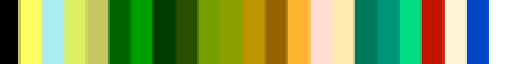

In [11]:
colors = [
    (0, 0, 0),            # No Data
    (1.0, 1.0, 0.392),    # Cropland, rainfed
    (0.667, 0.941, 0.941),# Cropland, irrigated or post-flooding
    (0.863, 0.941, 0.392),# Mosaic cropland / natural vegetation
    (0.784, 0.784, 0.392),# Mosaic natural vegetation / cropland
    (0, 0.392, 0),        # Tree cover, broadleaved, evergreen, closed to open
    (0, 0.627, 0),        # Tree cover, broadleaved, deciduous, closed to open
    (0, 0.235, 0),        # Tree cover, needleleaved, evergreen, closed to open
    (0.157, 0.314, 0),    # Tree cover, needleleaved, deciduous, closed to open
    (0.471, 0.627, 0),    # Tree cover, mixed leaf type (broadleaved and needleleaved)
    (0.549, 0.627, 0),    # Mosaic tree and shrub / herbaceous cover
    (0.745, 0.588, 0),    # Mosaic herbaceous cover / tree and shrub
    (0.588, 0.392, 0),    # Shrubland
    (1.0, 0.706, 0.196),  # Grassland
    (1.0, 0.863, 0.824),  # Lichens and mosses
    (1.0, 0.922, 0.686),  # Sparse vegetation (tree, shrub, herbaceous cover)
    (0, 0.471, 0.353),    # Tree cover, flooded, fresh or brackish water
    (0, 0.588, 0.471),    # Tree cover, flooded, saline water
    (0, 0.863, 0.51),     # Shrub or herbaceous cover, flooded, fresh/saline/brackish water
    (0.761, 0.078, 0), # Urban areas
    (1.0, 0.961, 0.843),    # Bare areas
    (0, 0.275, 0.784),  # Water bodies
    (1, 1, 1),    # Permanent snow and ice
]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

color_ranges = [(0,8), (8, 18), (18, 28), (28, 38), (38, 48), 
                (48, 58), (58, 68), (68, 78), (78, 88), 
                (88, 98), (98, 108), (108, 118), (118, 128), (128, 138),
                (138, 148), (148, 158), (158, 168), (168,178), (178,188),
                (188,198), (198,208), (208,218), (218,228)]

labels = ["No data", "Cropland, rainfed", "Cropland, irrigated or post-flooding",
          "Mosaic cropland / natural vegetation", "Mosaic natural vegetation / cropland",
          "Tree cover, broadleaved, evergreen", "Tree cover, broadleaved, deciduous",
          "Tree cover, needleleaved, evergreen", "Tree cover, needleleaved, deciduous",
          "Tree cover, mixed leaf type", "Mosaic tree and shrub / herbaceous cover",
          "Mosaic herbaceous cover / tree and shrub", "Shrubland", "Grassland",
          "Lichens and mosses", "Sparse vegetation", "Tree cover, flooded, fresh or brackish water",
          "Tree cover, flooded, saline water", "Shrub or herbaceous cover, flooded",
          "Urban areas", "Bare areas", "Water bodies", "Permanent snow and ice"]

# Create colormap
def create_cmap(colors, ranges):
    n = len(ranges)
    cmap_colors = []
    for i in range(n):
        start, end = ranges[i]
        for j in range(start, end + 1):
            cmap_colors.append(colors[i])
    return LinearSegmentedColormap.from_list(f'custom_cmap', cmap_colors, N=max([end for start, end in ranges]) + 1)

cmap = create_cmap(colors, color_ranges)
cmap


In [12]:
def plot_landcover(region_name): #plot the most recent landcover
    lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/newest/regrid/ESACCI-LC-L4-LCCS-Map-0_1_degrees_regrid-P1Y-2000_2015-v2.0.7cds_and_C3S-LC-L4-LCCS-Map-0_1_degrees-P1Y-2016_2022-v2.1.1_regridded.nc").lccs_class.sel(time=slice("2000-02", "2022-12"))
    labels = ["No data","Cropland, rainfed", "Cropland, irrigated or post-flooding",
            "Mosaic cropland / natural vegetation", "Mosaic natural vegetation / cropland",
            "Tree cover, broadleaved, evergreen", "Tree cover, broadleaved, deciduous",
            "Tree cover, needleleaved, evergreen", "Tree cover, needleleaved, deciduous",
            "Tree cover, mixed leaf type", "Mosaic tree and shrub / herbaceous cover",
            "Mosaic herbaceous cover / tree and shrub", "Shrubland", "Grassland",
            "Lichens and mosses", "Sparse vegetation", "Tree cover, flooded, fresh or brackish water",
            "Tree cover, flooded, saline water", "Shrub or herbaceous cover, flooded",
            "Urban areas", "Bare areas", "Water bodies", "Permanent snow and ice"]

    # Generate legend patches
    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

    if region_name == "IND": #IND, AUS, WEU, SA, SSA, CAL
        reg_lat = slice(7, 33)
        reg_lon = slice(68, 94)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    if region_name == "BAH": #IND, AUS, WEU, SA, SSA, CAL
        reg_lat = slice(19,37) 
        reg_lon = slice(81,99)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "AUS":
        reg_lat = slice(-40, -20)
        reg_lon = slice(135, 155)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "WEU":
        reg_lat = slice(41, 57)
        reg_lon = slice(-3, 16)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "SA":
        reg_lat = slice(-37, -13)
        reg_lon = slice(11, 38)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "ARG":
        reg_lat = slice(-58, -21)
        reg_lon = slice(-80, -50)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "CAL":
        reg_lat = slice(30, 43)
        reg_lon = slice(-126, -113)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
    
    # Add legend
    plt.style.use('default')
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
    landcover_region = lc.sel(lon = reg_lon, lat = reg_lat).where(region_mask == 1)
    im = landcover_region.sel(time="2022-12").plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(),cmap=cmap, vmin = 0, vmax = 228)#, norm=norm)
    contour = ax.contour(region_mask.lon, region_mask.lat, np.isnan(region_mask), colors='black', linewidths=2, transform=ccrs.PlateCarree())

    ax.set_title("", color='black')  
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.show()
    return landcover_region

## Europe

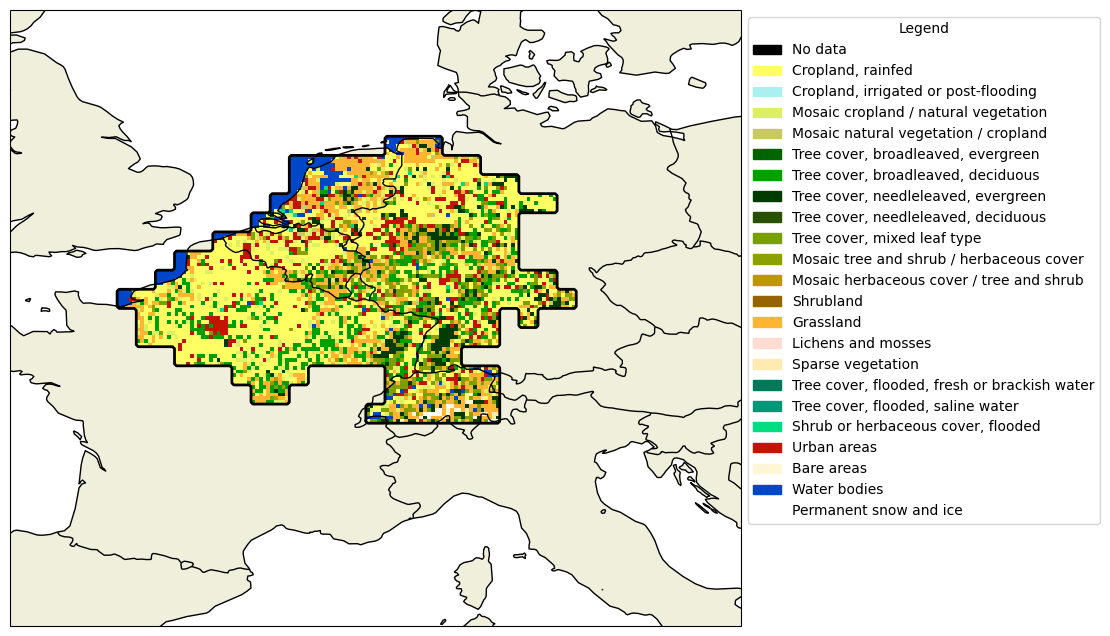

In [13]:
landcover_EU = plot_landcover("WEU")

### Starting month

First define the starting month of most droughts

In [14]:
EVI_region_EU_sm, EVI_region_grid_an_MYD_EU_sm, EVI_region_grid_an_nd_EU_sm, spei_region_EU_sm, SPEI_region_grid_MYD_EU_sm, SPEI_region_grid_nd_EU_sm = MYD_EVI_starting_month("WEU")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


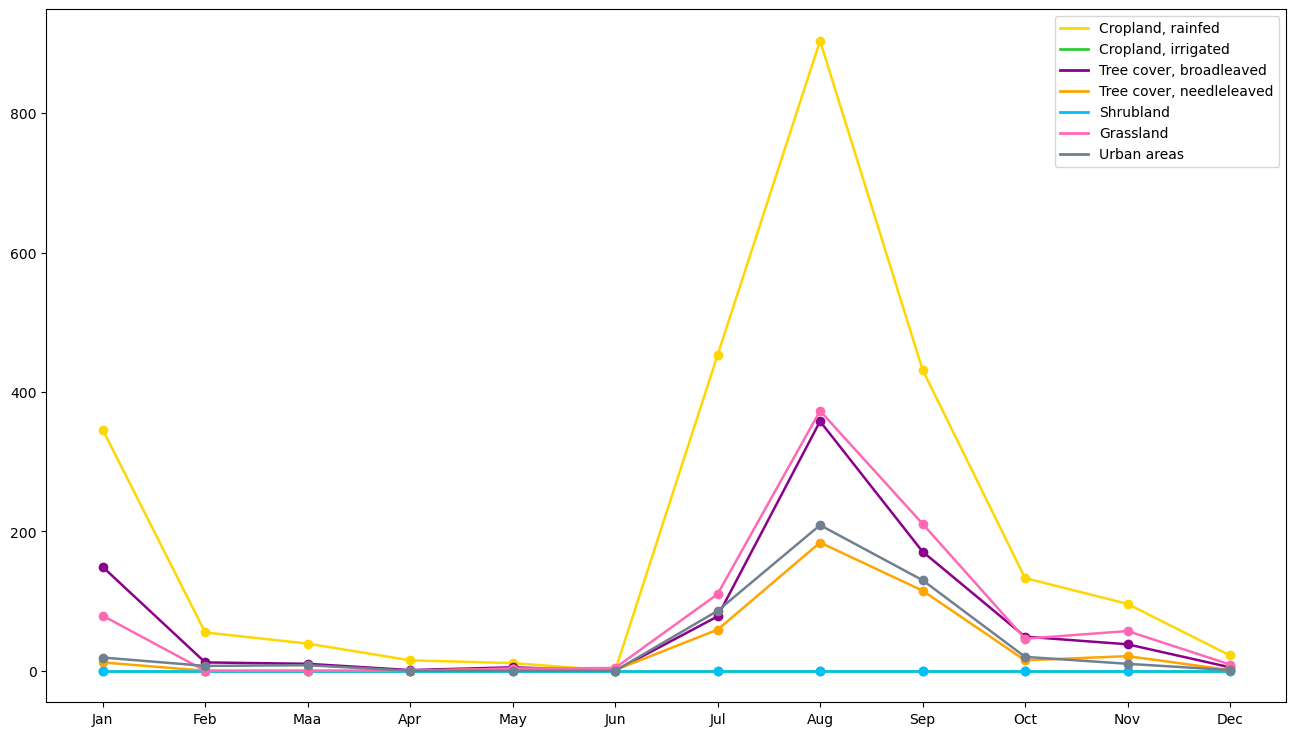

In [15]:
starting_month_plot(EVI_region_grid_an_MYD_EU_sm, landcover_EU)

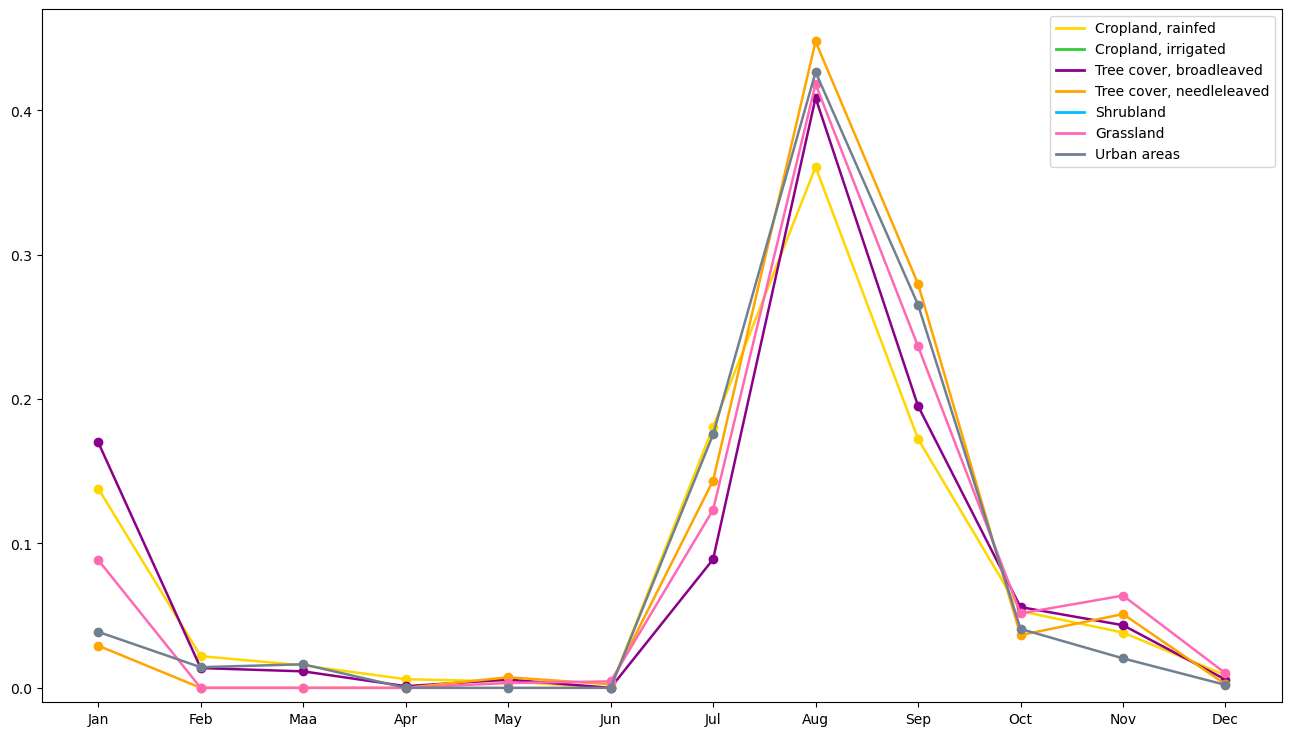

In [16]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_EU_sm, landcover_EU)

Most droughts start in august, so i'll take jul, aug, sep.

### Climatology

In [17]:
EVI_region_EU0, EVI_region_grid_an_MYD_EU0, EVI_region_grid_an_nd_EU0, spei_region_EU0, SPEI_region_grid_MYD_EU0, SPEI_region_grid_nd_EU0 = MYD_EVI_yearbefore_first_second("WEU", 11, 0)

In [18]:
EVI_region_EU1, EVI_region_grid_an_MYD_EU1, EVI_region_grid_an_nd_EU1, spei_region_EU1, SPEI_region_grid_MYD_EU1, SPEI_region_grid_nd_EU1 = MYD_EVI_yearbefore_first_second("WEU", 11, 1)

In [19]:
EVI_region_EU2, EVI_region_grid_an_MYD_EU2, EVI_region_grid_an_nd_EU2, spei_region_EU2, SPEI_region_grid_MYD_EU2, SPEI_region_grid_nd_EU2 = MYD_EVI_yearbefore_first_second("WEU", 11, 2)

In [20]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_EU2, landcover_EU, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 6901 (46.41% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 2373 (15.96% of total)
needleleaved: 1344 (9.04% of total)
shrubland: 0 (0.00% of total)
grassland: 2988 (20.09% of total)
urban: 1264 (8.50% of total)


Now filter out August (month 8) ± 1 month.

In [21]:
EVI_region_grid_an_MYD_EU0_filtered = filter_starting_month(EVI_region_grid_an_MYD_EU0, [7,8,9])
EVI_region_grid_an_MYD_EU1_filtered = filter_starting_month(EVI_region_grid_an_MYD_EU1, [7,8,9])
EVI_region_grid_an_MYD_EU2_filtered = filter_starting_month(EVI_region_grid_an_MYD_EU2, [7,8,9])

Check if there are still enough gridcells now. 

In [22]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_EU2_filtered, landcover_EU, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 1599 (36.74% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 696 (15.99% of total)
needleleaved: 533 (12.25% of total)
shrubland: 0 (0.00% of total)
grassland: 1167 (26.82% of total)
urban: 357 (8.20% of total)


No shrubland or irrigated cropland MYDs present in Europe, so it doesn't matter if we put it in there, because it won't plot anything anyway for those landcovers.

/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


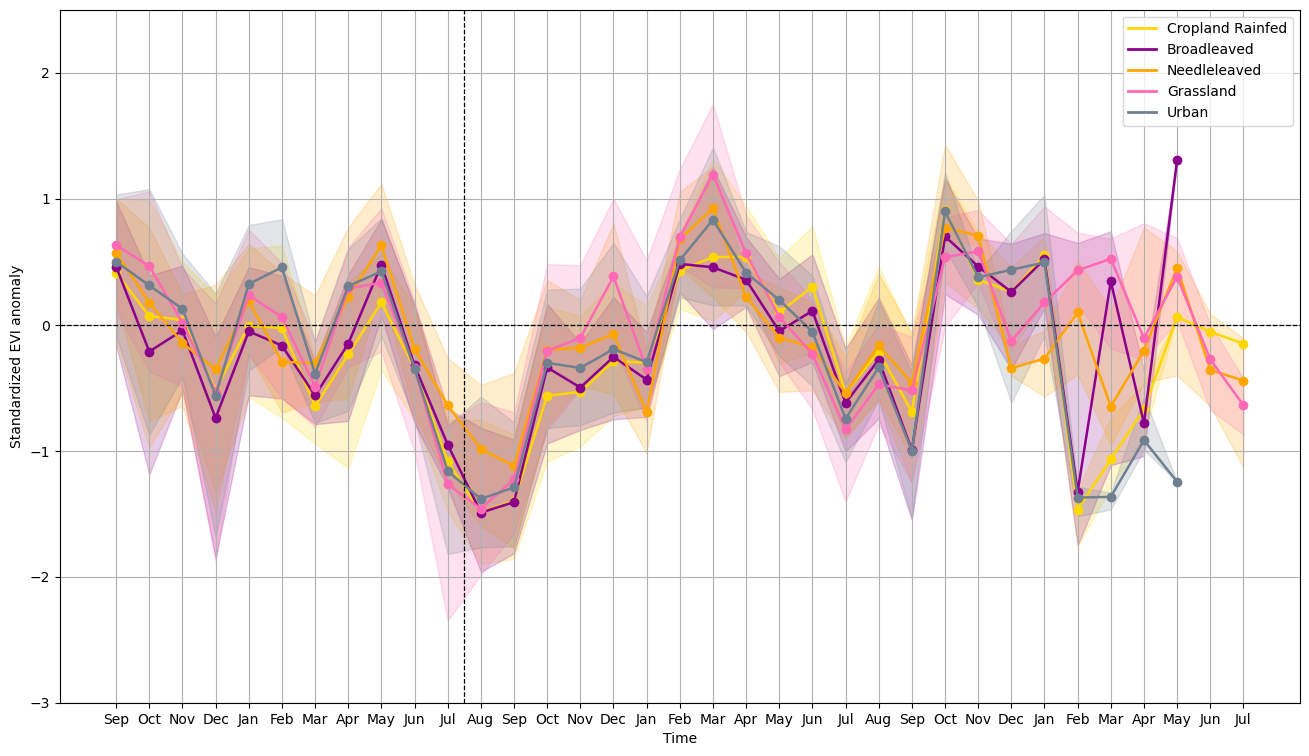

In [23]:
region_name = "WEU"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_EU0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_EU1_filtered
EVI_region_lc_MYDs2 =  EVI_region_grid_an_MYD_EU2_filtered
starting_month = 8
landcover = landcover_EU
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig = False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## California

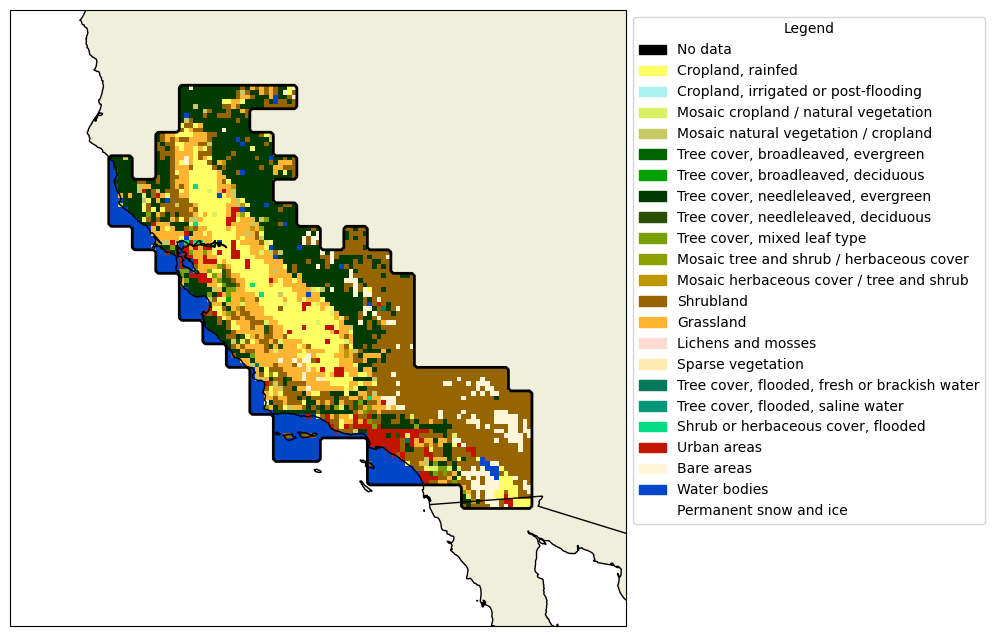

In [24]:
landcover_CAL = plot_landcover("CAL")

First define the starting month of most droughts

In [25]:
EVI_region_CAL_sm, EVI_region_grid_an_MYD_CAL_sm, EVI_region_grid_an_nd_CAL_sm, spei_region_CAL_sm, SPEI_region_grid_MYD_CAL_sm, SPEI_region_grid_nd_CAL_sm = MYD_EVI_starting_month("CAL")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


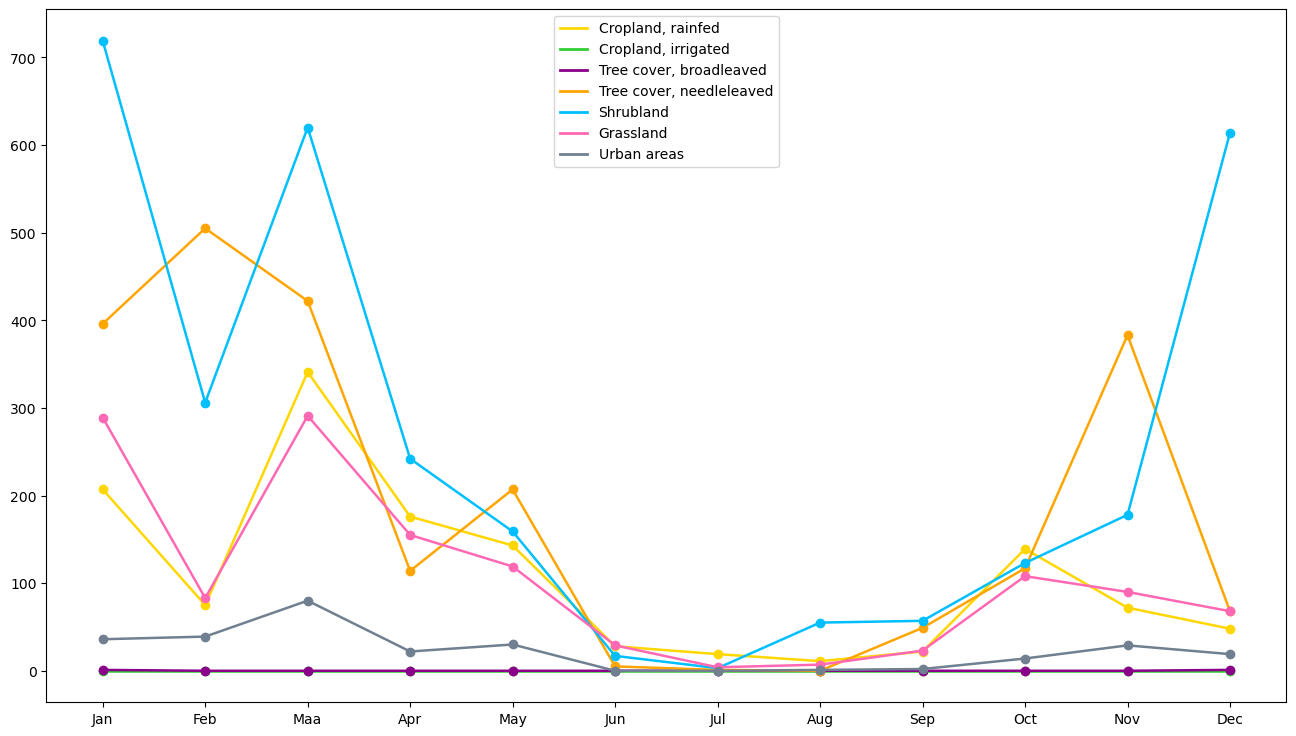

In [26]:
starting_month_plot(EVI_region_grid_an_MYD_CAL_sm, landcover_CAL)

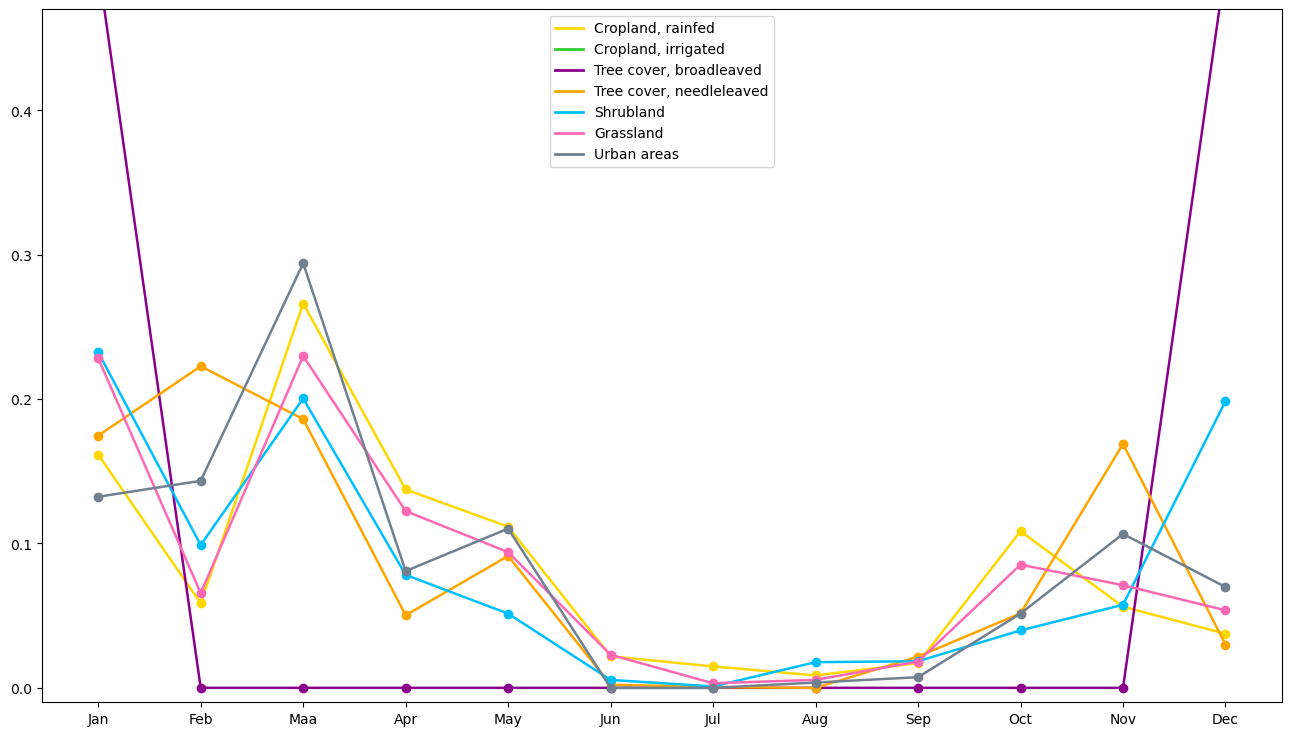

In [27]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_CAL_sm, landcover_CAL)

Most droughts start in march, so i'll take feb, mar, apr.

In [28]:
EVI_region_CAL0, EVI_region_grid_an_MYD_CAL0, EVI_region_grid_an_nd_CAL0, spei_region_CAL0, SPEI_region_grid_MYD_CAL0, SPEI_region_grid_nd_CAL0 = MYD_EVI_yearbefore_first_second("CAL", 11, 0)

In [29]:
EVI_region_CAL1, EVI_region_grid_an_MYD_CAL1, EVI_region_grid_an_nd_CAL1, spei_region_CAL1, SPEI_region_grid_MYD_CAL1, SPEI_region_grid_nd_CAL1 = MYD_EVI_yearbefore_first_second("CAL", 11, 1)

In [30]:
EVI_region_CAL2, EVI_region_grid_an_MYD_CAL2, EVI_region_grid_an_nd_CAL2, spei_region_CAL2, SPEI_region_grid_MYD_CAL2, SPEI_region_grid_nd_CAL2 = MYD_EVI_yearbefore_first_second("CAL", 11, 2)

In [31]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_CAL2, landcover_CAL, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 14484 (18.83% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 2 (0.00% of total)
needleleaved: 19316 (25.11% of total)
shrubland: 28697 (37.30% of total)
grassland: 12155 (15.80% of total)
urban: 2278 (2.96% of total)


In [32]:
EVI_region_grid_an_MYD_CAL0_filtered = filter_starting_month(EVI_region_grid_an_MYD_CAL0, [2,3,4])
EVI_region_grid_an_MYD_CAL1_filtered = filter_starting_month(EVI_region_grid_an_MYD_CAL1, [2,3,4])
EVI_region_grid_an_MYD_CAL2_filtered = filter_starting_month(EVI_region_grid_an_MYD_CAL2, [2,3,4])

In [33]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_CAL2_filtered, landcover_CAL, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 7940 (22.29% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 0 (0.00% of total)
needleleaved: 8535 (23.96% of total)
shrubland: 11660 (32.73% of total)
grassland: 6504 (18.26% of total)
urban: 987 (2.77% of total)


No irrigated cropland MYDs present in California, so it doesn't matter if we put it in there, because it won't plot anything anyway for those landcovers. Broadleaved only 2 gridcells, so delete it.

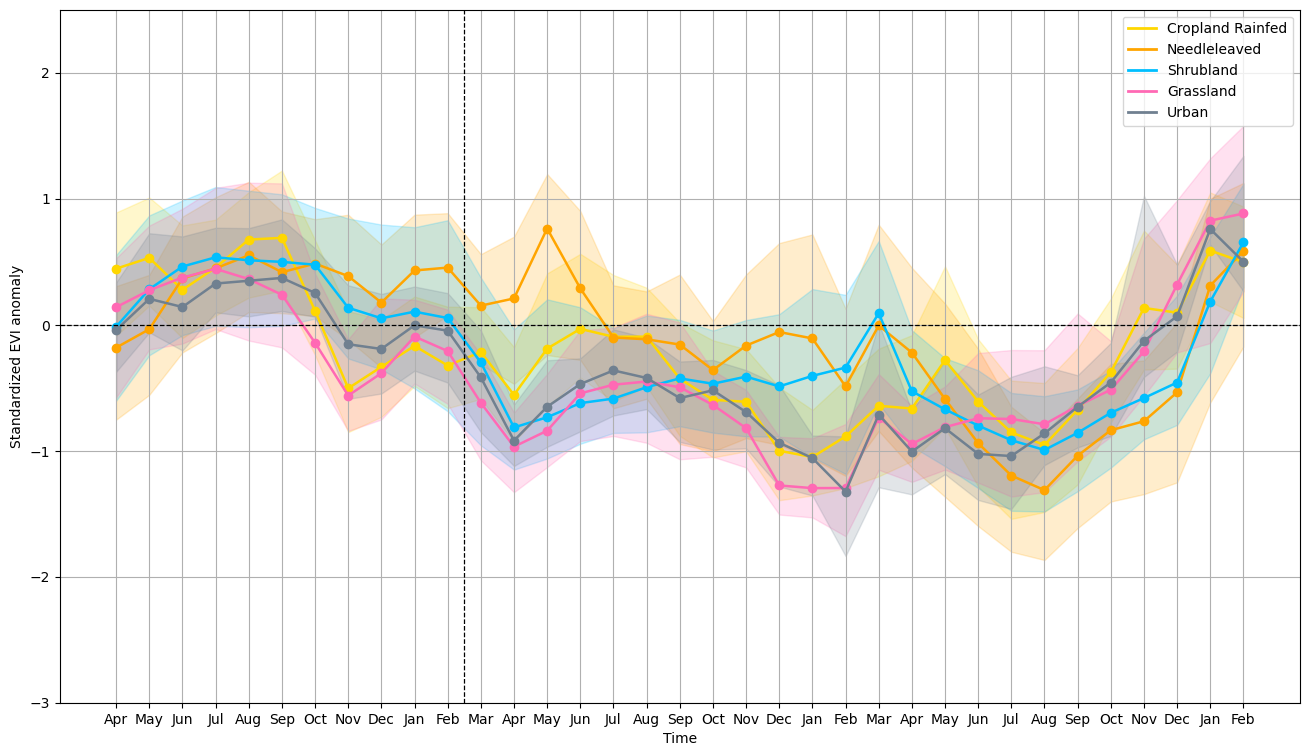

In [34]:
region_name = "CAL"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_CAL0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_CAL1_filtered
EVI_region_lc_MYDs2 =  EVI_region_grid_an_MYD_CAL2_filtered
starting_month = 3
landcover = landcover_CAL
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig= False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## Australia

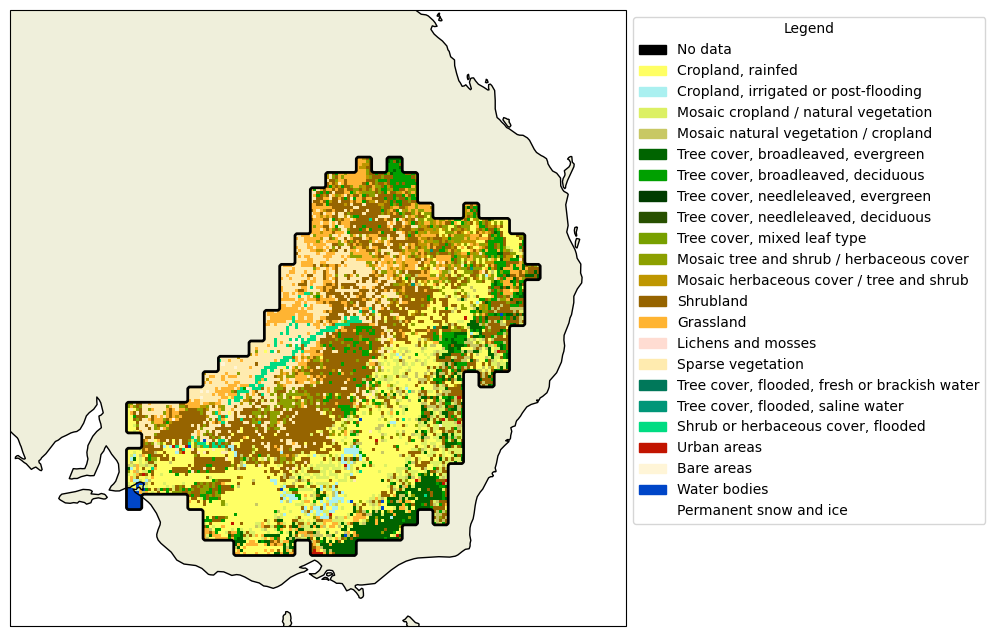

In [35]:
landcover_AUS = plot_landcover("AUS")

First define the starting month

In [36]:
EVI_region_AUS_sm, EVI_region_grid_an_MYD_AUS_sm, EVI_region_grid_an_nd_AUS_sm, spei_region_AUS_sm, SPEI_region_grid_MYD_AUS_sm, SPEI_region_grid_nd_AUS_sm = MYD_EVI_starting_month("AUS")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


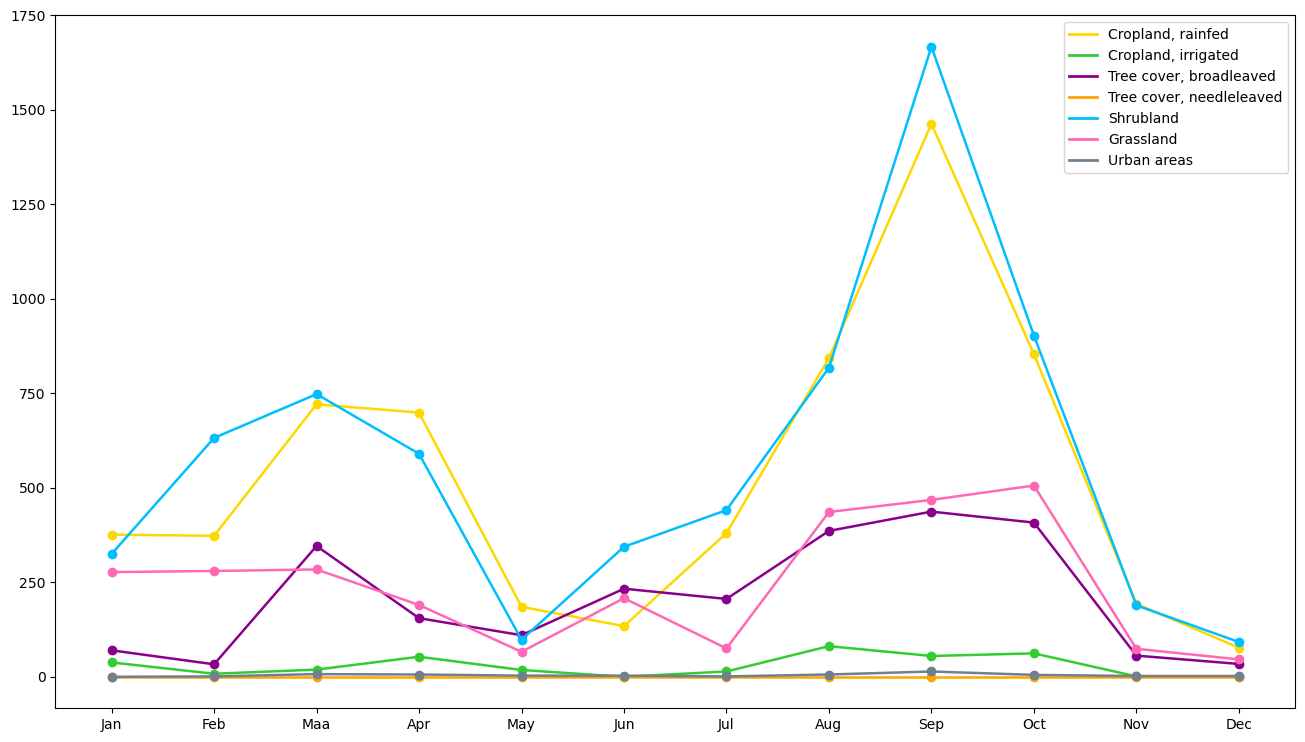

In [37]:
starting_month_plot(EVI_region_grid_an_MYD_AUS_sm, landcover_AUS)

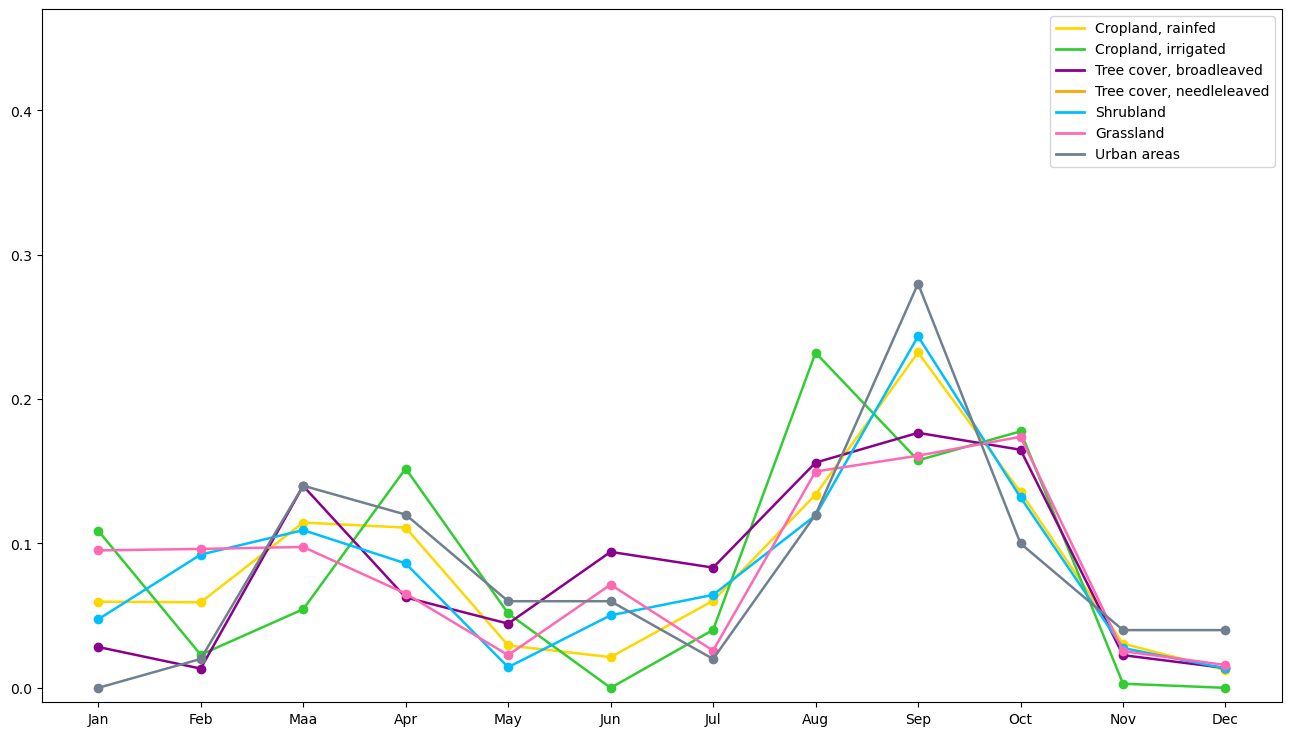

In [38]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_AUS_sm, landcover_AUS)

Most droughts start in sep, so i'll take aug, sep, oct.

In [39]:
EVI_region_AUS0, EVI_region_grid_an_MYD_AUS0, EVI_region_grid_an_nd_AUS0, spei_region_AUS0, SPEI_region_grid_MYD_AUS0, SPEI_region_grid_nd_AUS0 = MYD_EVI_yearbefore_first_second("AUS", 11, 0)

In [40]:
EVI_region_AUS1, EVI_region_grid_an_MYD_AUS1, EVI_region_grid_an_nd_AUS1, spei_region_AUS1, SPEI_region_grid_MYD_AUS1, SPEI_region_grid_nd_AUS1 = MYD_EVI_yearbefore_first_second("AUS", 11, 1)

In [41]:
EVI_region_AUS2, EVI_region_grid_an_MYD_AUS2, EVI_region_grid_an_nd_AUS2, spei_region_AUS2, SPEI_region_grid_MYD_AUS2, SPEI_region_grid_nd_AUS2 = MYD_EVI_yearbefore_first_second("AUS", 11, 2)

In [42]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_AUS2, landcover_AUS, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")

Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 42391 (28.10% of total)
cropland_irrigated: 1939 (1.29% of total)
broadleaved: 18278 (12.12% of total)
needleleaved: 0 (0.00% of total)
shrubland: 60464 (40.08% of total)
grassland: 27467 (18.21% of total)
urban: 306 (0.20% of total)


In [43]:
EVI_region_grid_an_MYD_AUS0_filtered = filter_starting_month(EVI_region_grid_an_MYD_AUS0, [8,9,10])
EVI_region_grid_an_MYD_AUS1_filtered = filter_starting_month(EVI_region_grid_an_MYD_AUS1, [8,9,10])
EVI_region_grid_an_MYD_AUS2_filtered = filter_starting_month(EVI_region_grid_an_MYD_AUS2, [8,9,10])

In [44]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_AUS2_filtered, landcover_AUS, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 9863 (23.74% of total)
cropland_irrigated: 231 (0.56% of total)
broadleaved: 5176 (12.46% of total)
needleleaved: 0 (0.00% of total)
shrubland: 17996 (43.31% of total)
grassland: 8238 (19.83% of total)
urban: 44 (0.11% of total)


No needleleaved MYDs present in Australia, so it doesn't matter if we put it in there, because it won't plot anything anyway for that landcover. Not that many urban gridcells, look at what they do to decide if we want to include them.

/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


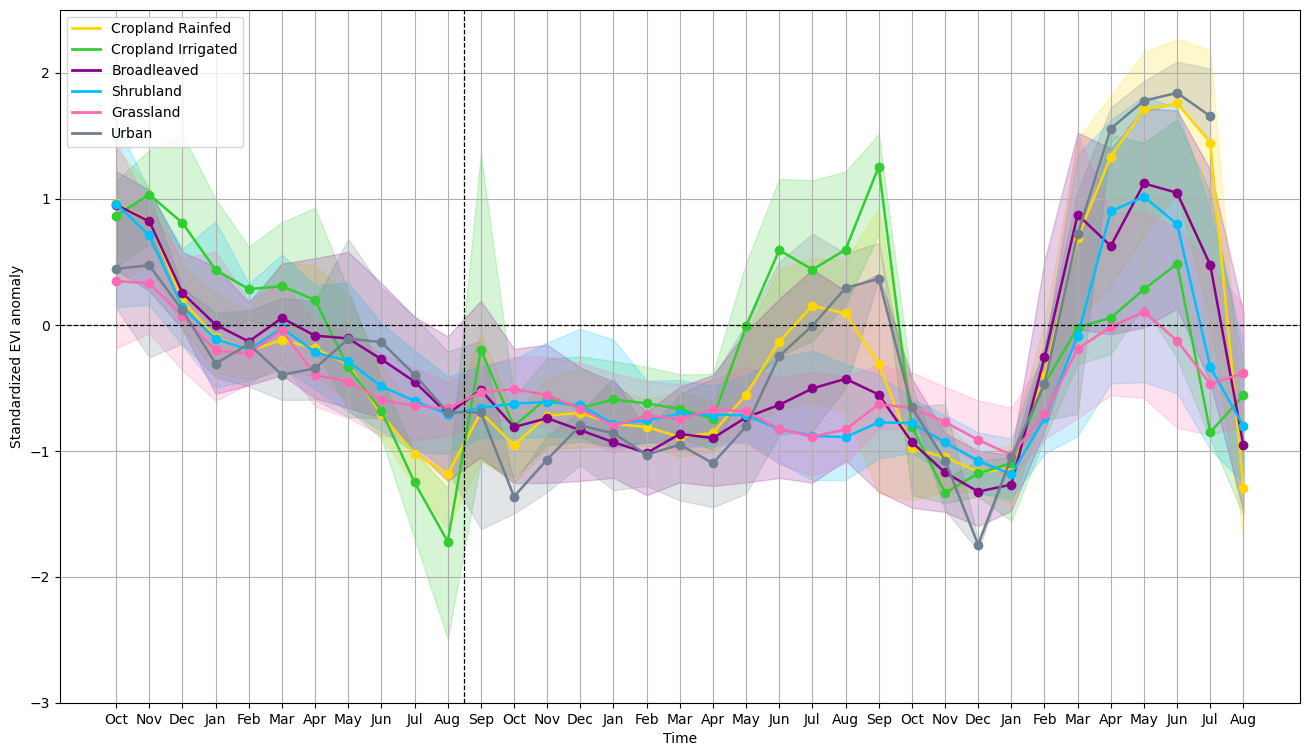

In [45]:
region_name = "AUS"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_AUS0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_AUS1_filtered
EVI_region_lc_MYDs2 =  EVI_region_grid_an_MYD_AUS2_filtered
starting_month = 9
landcover = landcover_AUS
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig= False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## One figure with CAL, WEU and AUS

0
CAL


/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


1
WEU


/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/ruiij001/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


2
AUS


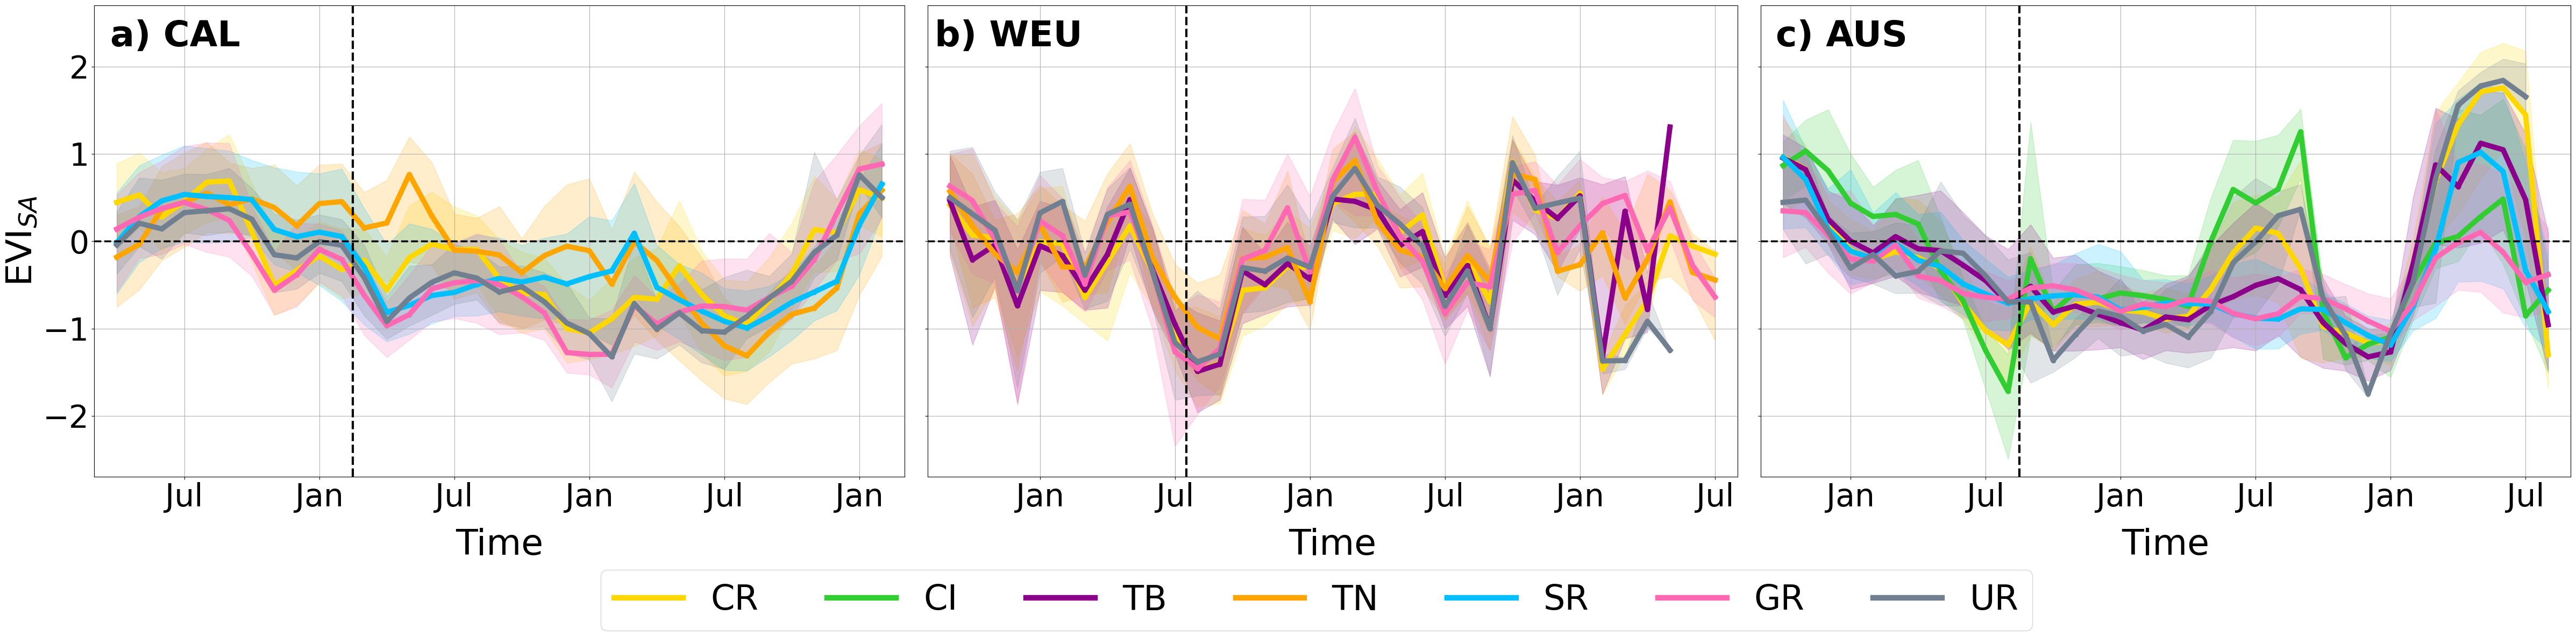

In [46]:
EVI_region_lc_MYDs_list = [
    (EVI_region_grid_an_MYD_CAL0_filtered, EVI_region_grid_an_MYD_CAL1_filtered, EVI_region_grid_an_MYD_CAL2_filtered),
    (EVI_region_grid_an_MYD_EU0_filtered, EVI_region_grid_an_MYD_EU1_filtered, EVI_region_grid_an_MYD_EU2_filtered),
    (EVI_region_grid_an_MYD_AUS0_filtered, EVI_region_grid_an_MYD_AUS1_filtered, EVI_region_grid_an_MYD_AUS2_filtered)
]

region_names = ["CAL","WEU","AUS"]
suptitle = ""
ymin = -2.7
ymax = 2.7
ylabel = r"EVI$_{SA}$"
shade = True
starting_month = [3,8,9]
landcover = [landcover_CAL,landcover_EU,landcover_AUS]
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'needleleaved', 'shrubland', 'grassland', 'urban'], ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban'], ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig = True
line_moreyears_some_one_figure(region_names=region_names, suptitle=suptitle, EVI_region_lc_MYDs_list=EVI_region_lc_MYDs_list, starting_months=starting_month, landcovers=landcover, included_landcovers_list=included_landcovers, ymin=ymin, ymax=ymax, ylabel=ylabel, shade=shade, savefig=savefig)


## Brahmaputra

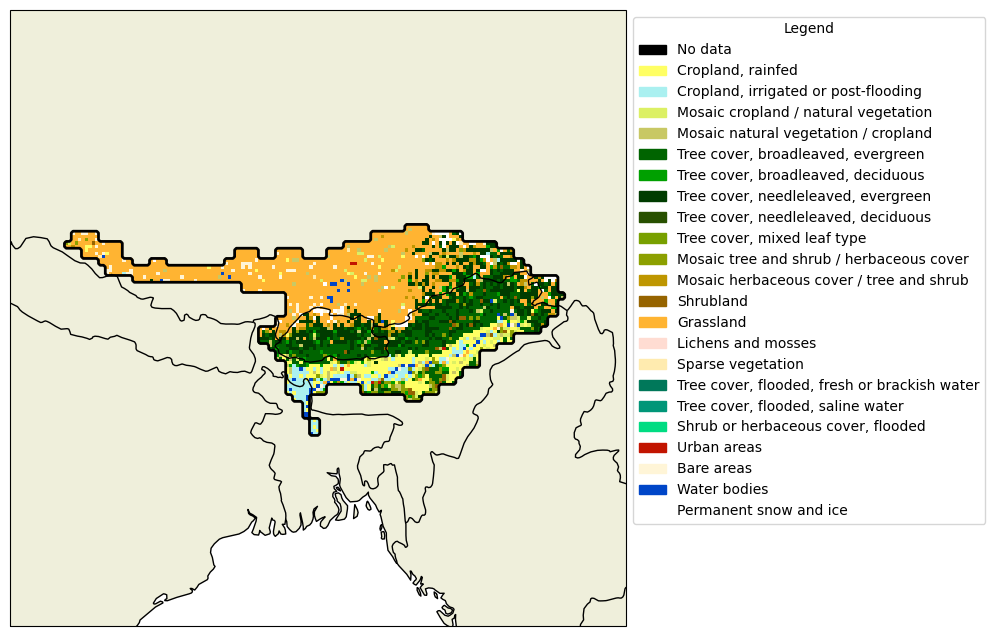

In [47]:
landcover_BAH = plot_landcover("BAH")

In [48]:
EVI_region_BAH_sm, EVI_region_grid_an_MYD_BAH_sm, EVI_region_grid_an_nd_BAH_sm, spei_region_BAH_sm, SPEI_region_grid_MYD_BAH_sm, SPEI_region_grid_nd_BAH_sm = MYD_EVI_starting_month("BAH")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


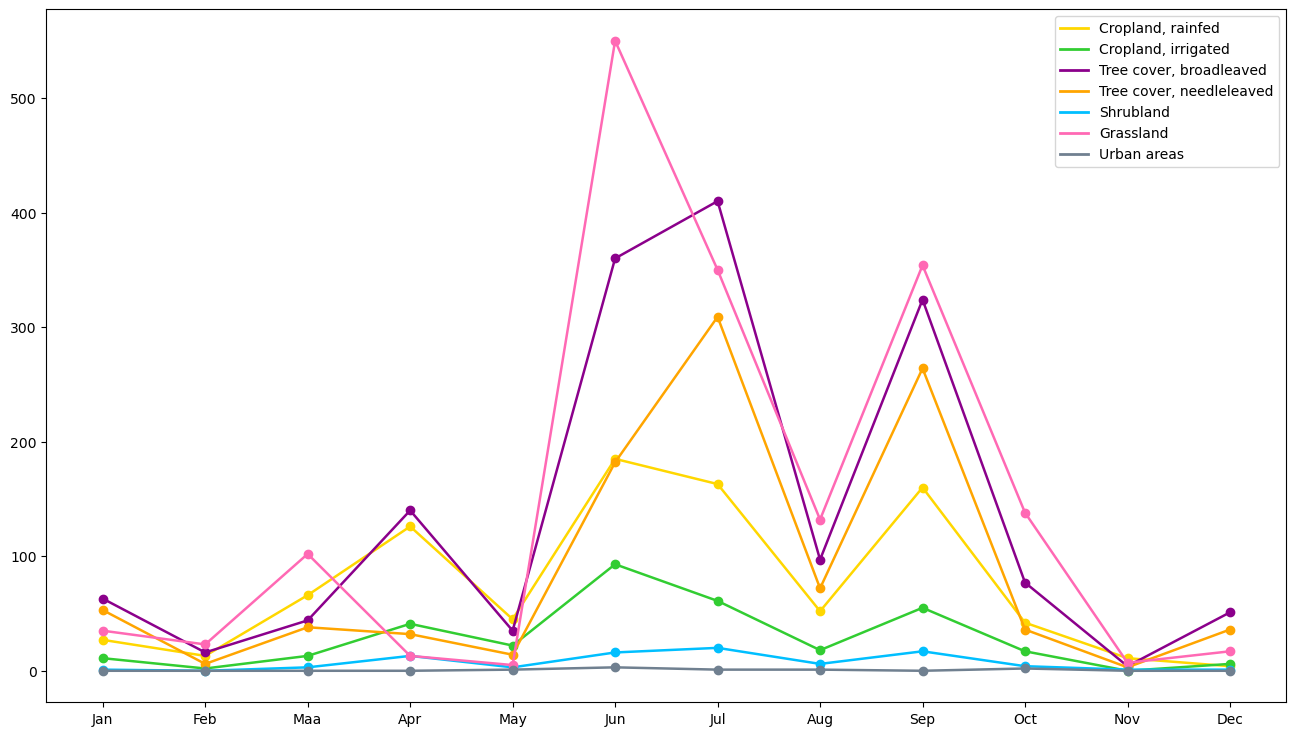

In [49]:
starting_month_plot(EVI_region_grid_an_MYD_BAH_sm, landcover_BAH)

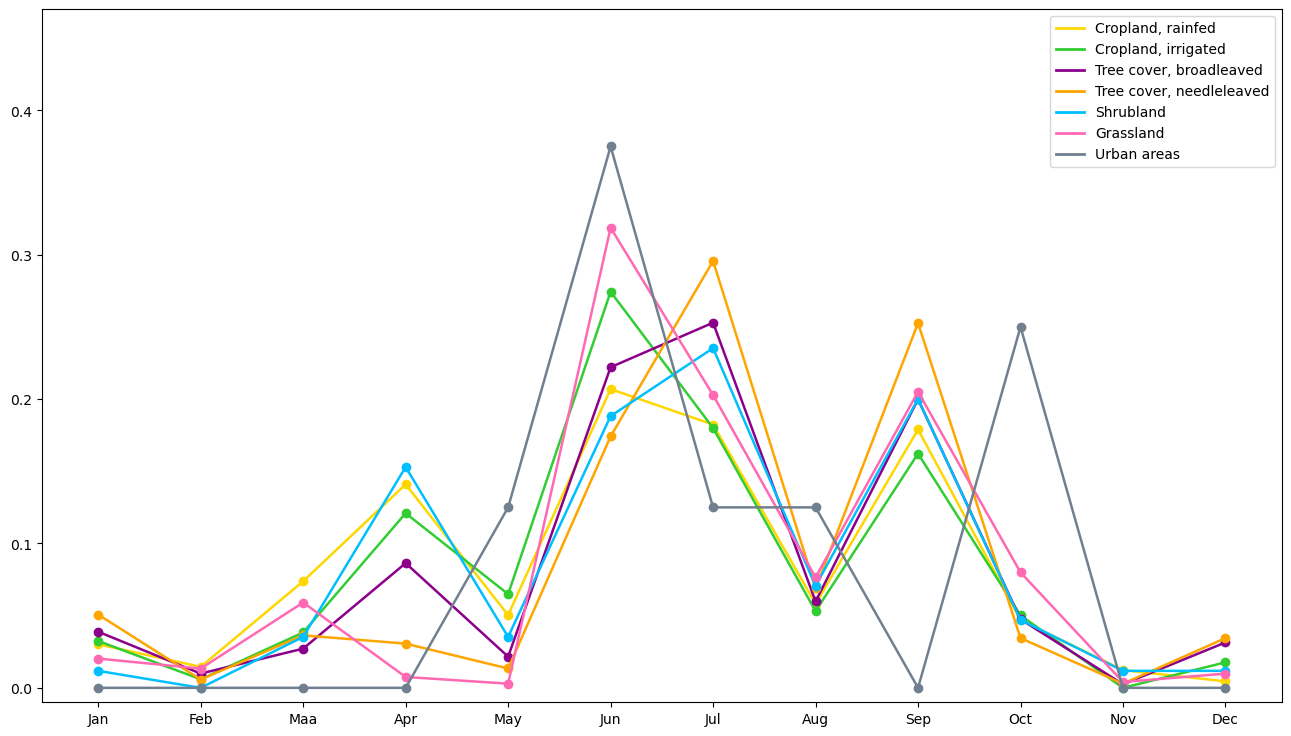

In [50]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_BAH_sm, landcover_BAH)

Most droughts start june, so i'll take may, jun, jul.

In [51]:
EVI_region_BAH0, EVI_region_grid_an_MYD_BAH0, EVI_region_grid_an_nd_BAH0, spei_region_BAH0, SPEI_region_grid_MYD_BAH0, SPEI_region_grid_nd_BAH0 = MYD_EVI_yearbefore_first_second("BAH", 11, 0)

In [52]:
EVI_region_BAH1, EVI_region_grid_an_MYD_BAH1, EVI_region_grid_an_nd_BAH1, spei_region_BAH1, SPEI_region_grid_MYD_BAH1, SPEI_region_grid_nd_BAH1 = MYD_EVI_yearbefore_first_second("BAH", 11, 1)

In [53]:
EVI_region_BAH2, EVI_region_grid_an_MYD_BAH2, EVI_region_grid_an_nd_BAH2, spei_region_BAH2, SPEI_region_grid_MYD_BAH2, SPEI_region_grid_nd_BAH2 = MYD_EVI_yearbefore_first_second("BAH", 11, 2)

In [54]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_BAH2, landcover_BAH, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 5733 (16.11% of total)
cropland_irrigated: 1983 (5.57% of total)
broadleaved: 11363 (31.94% of total)
needleleaved: 8555 (24.04% of total)
shrubland: 668 (1.88% of total)
grassland: 7241 (20.35% of total)
urban: 37 (0.10% of total)


In [55]:
EVI_region_grid_an_MYD_BAH0_filtered = filter_starting_month(EVI_region_grid_an_MYD_BAH0, [5,6,7])
EVI_region_grid_an_MYD_BAH1_filtered = filter_starting_month(EVI_region_grid_an_MYD_BAH1, [5,6,7])
EVI_region_grid_an_MYD_BAH2_filtered = filter_starting_month(EVI_region_grid_an_MYD_BAH2, [5,6,7])

In [56]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_BAH2_filtered, landcover_BAH, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 3387 (14.92% of total)
cropland_irrigated: 1059 (4.66% of total)
broadleaved: 7221 (31.80% of total)
needleleaved: 6238 (27.47% of total)
shrubland: 420 (1.85% of total)
grassland: 4378 (19.28% of total)
urban: 4 (0.02% of total)


Not that many urban and shrubland gridcells, look at what they do to decide if we want to include them. Shrublands acts very weird, don't include it. 

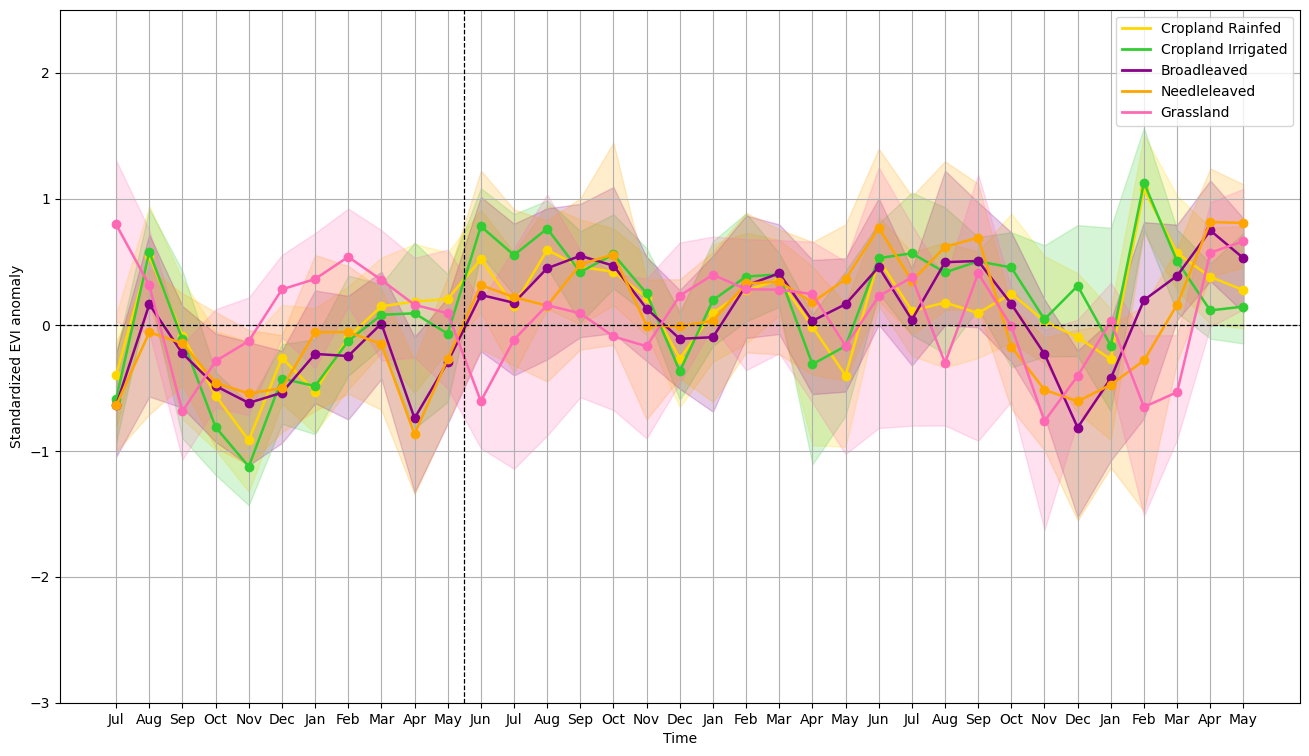

In [57]:
region_name = "BAH"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_BAH0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_BAH1_filtered
EVI_region_lc_MYDs2 = EVI_region_grid_an_MYD_BAH2_filtered
starting_month = 6
landcover = landcover_BAH
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'grassland']
savefig= False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## South-Africa

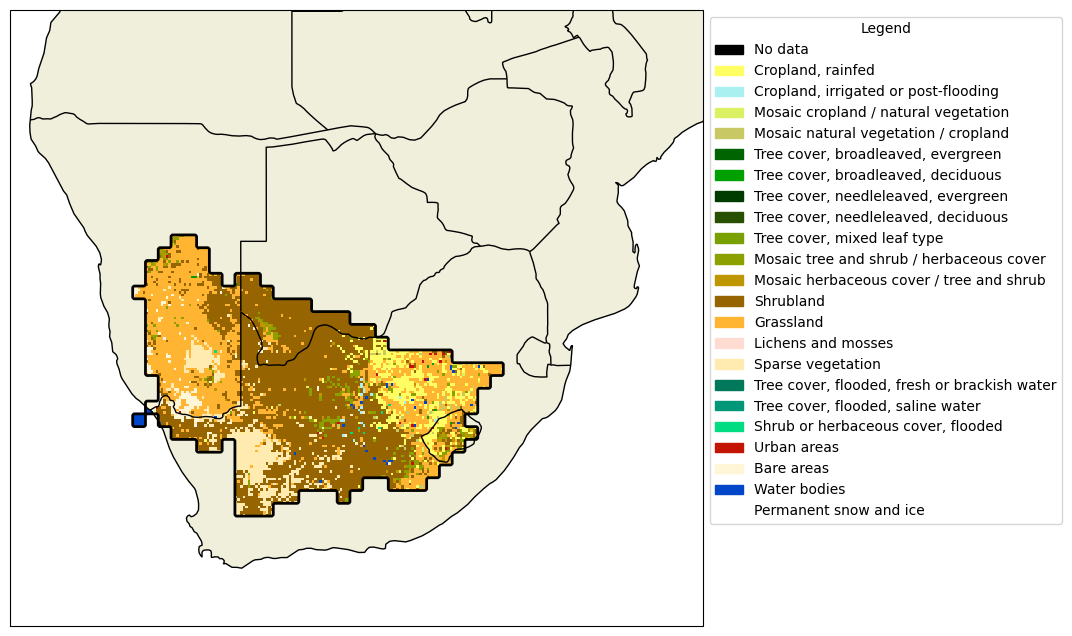

In [58]:
landcover_SA = plot_landcover("SA")

Find the starting month

In [59]:
EVI_region_SA_sm, EVI_region_grid_an_MYD_SA_sm, EVI_region_grid_an_nd_SA_sm, spei_region_SA_sm, SPEI_region_grid_MYD_SA_sm, SPEI_region_grid_nd_SA_sm = MYD_EVI_starting_month("SA")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


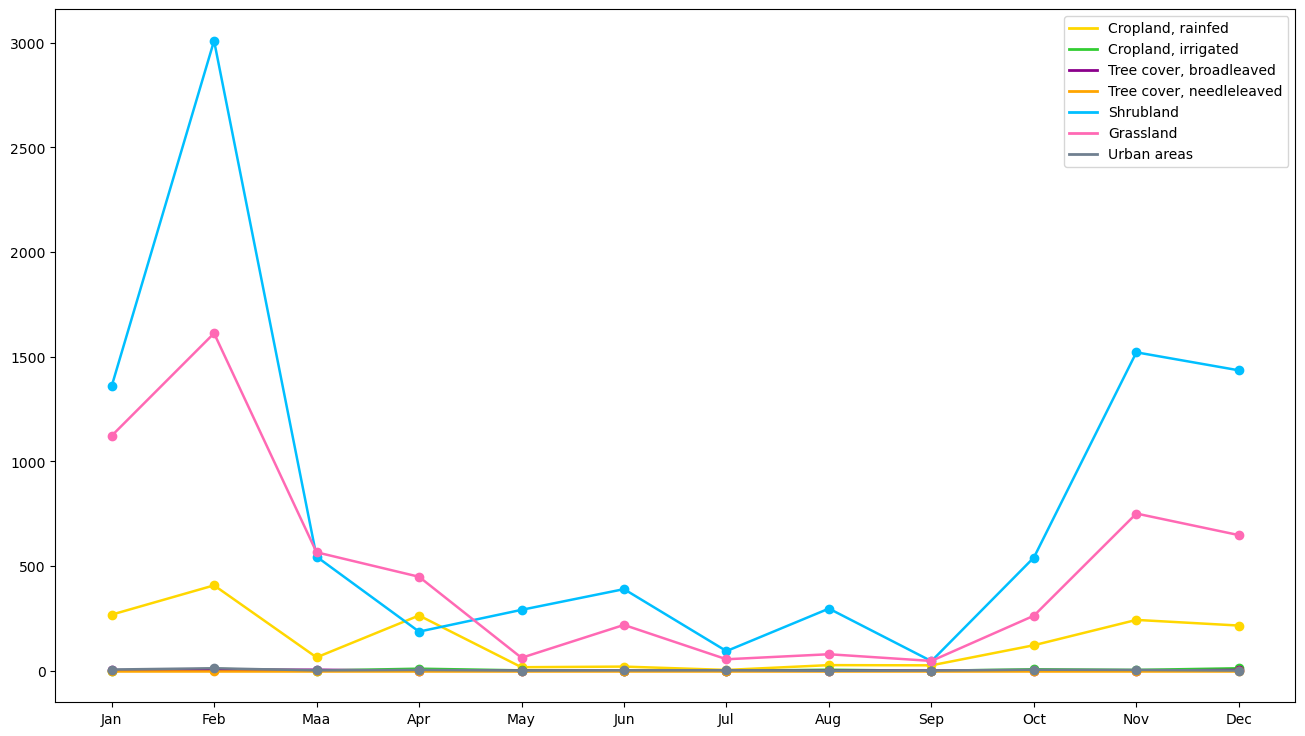

In [60]:
starting_month_plot(EVI_region_grid_an_MYD_SA_sm, landcover_SA)

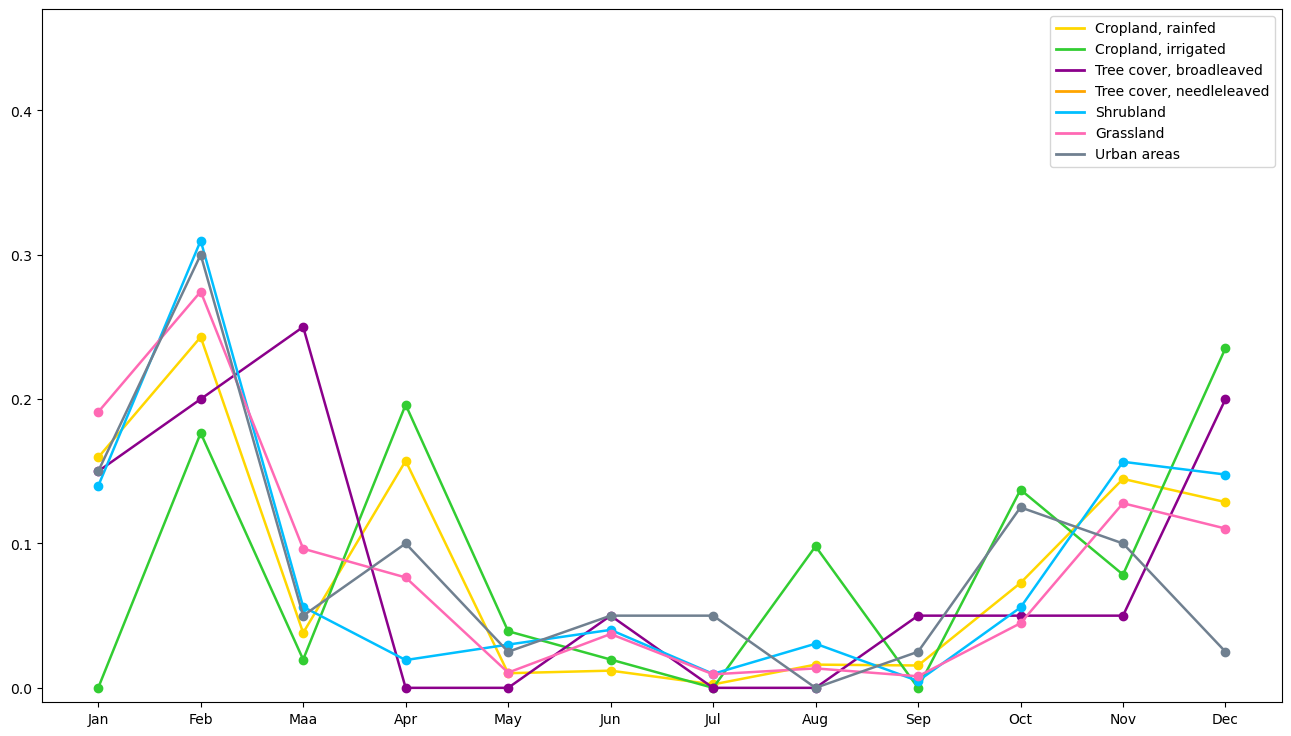

In [61]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_SA_sm, landcover_SA)

Most droughts start in feb, so i'll choose jan,feb,mar.

In [62]:
EVI_region_SA0, EVI_region_grid_an_MYD_SA0, EVI_region_grid_an_nd_SA0, spei_region_SA0, SPEI_region_grid_MYD_SA0, SPEI_region_grid_nd_SA0 = MYD_EVI_yearbefore_first_second("SA", 11, 0)

In [63]:
EVI_region_SA1, EVI_region_grid_an_MYD_SA1, EVI_region_grid_an_nd_SA1, spei_region_SA1, SPEI_region_grid_MYD_SA1, SPEI_region_grid_nd_SA1 = MYD_EVI_yearbefore_first_second("SA", 11, 1)

In [64]:
EVI_region_SA2, EVI_region_grid_an_MYD_SA2, EVI_region_grid_an_nd_SA2, spei_region_SA2, SPEI_region_grid_MYD_SA2, SPEI_region_grid_nd_SA2 = MYD_EVI_yearbefore_first_second("SA", 11, 2)

In [65]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_SA2, landcover_SA, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 13896 (10.49% of total)
cropland_irrigated: 331 (0.25% of total)
broadleaved: 149 (0.11% of total)
needleleaved: 0 (0.00% of total)
shrubland: 74962 (56.57% of total)
grassland: 42811 (32.31% of total)
urban: 366 (0.28% of total)


In [66]:
EVI_region_grid_an_MYD_SA0_filtered = filter_starting_month(EVI_region_grid_an_MYD_SA0, [1,2,3])
EVI_region_grid_an_MYD_SA1_filtered = filter_starting_month(EVI_region_grid_an_MYD_SA1, [1,2,3])
EVI_region_grid_an_MYD_SA2_filtered = filter_starting_month(EVI_region_grid_an_MYD_SA2, [1,2,3])

In [67]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_SA2_filtered, landcover_SA, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 4170 (12.41% of total)
cropland_irrigated: 137 (0.41% of total)
broadleaved: 42 (0.13% of total)
needleleaved: 0 (0.00% of total)
shrubland: 17611 (52.42% of total)
grassland: 11568 (34.43% of total)
urban: 67 (0.20% of total)


No needleleaved and not that many broadleaved gridcells, look at what they do to decide if we want to include them. Broadleaved acts very weird, don't include it. 

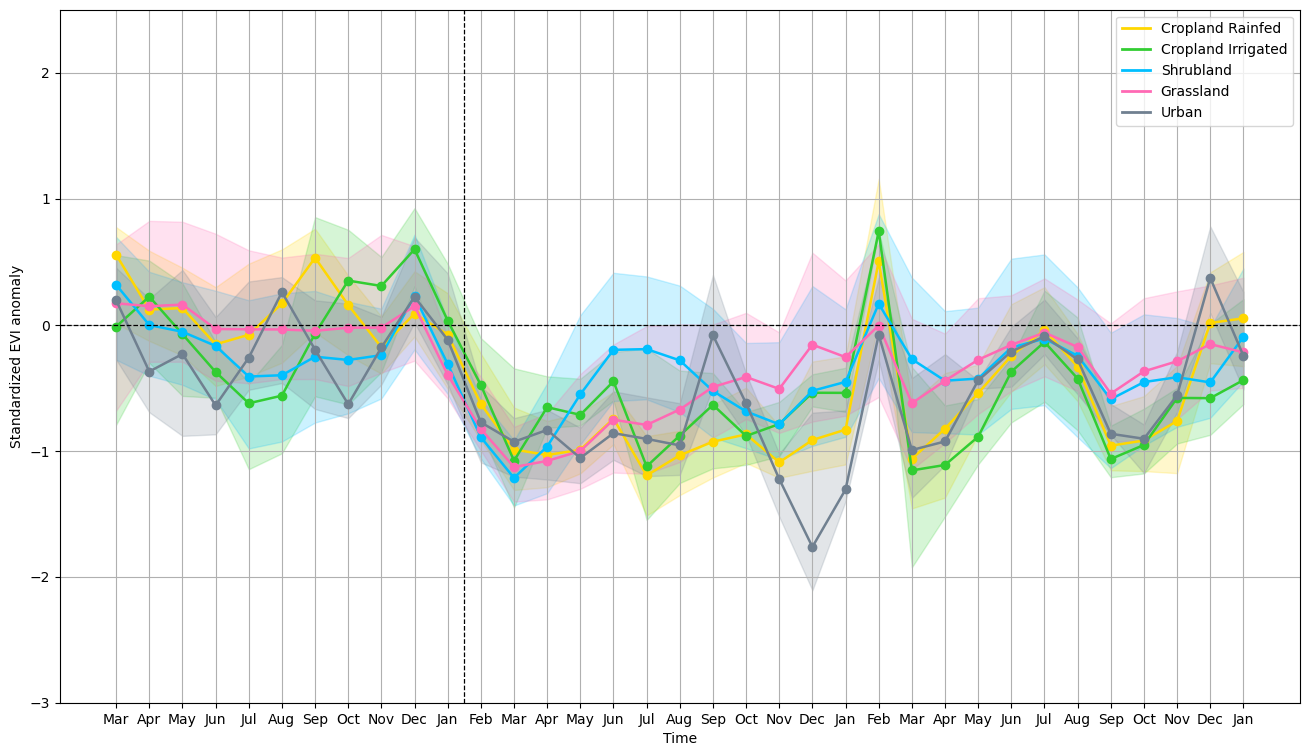

In [68]:
region_name = "SA"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_SA0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_SA1_filtered
EVI_region_lc_MYDs2 =  EVI_region_grid_an_MYD_SA2_filtered
starting_month = 2
landcover = landcover_SA
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig = False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## Argentina

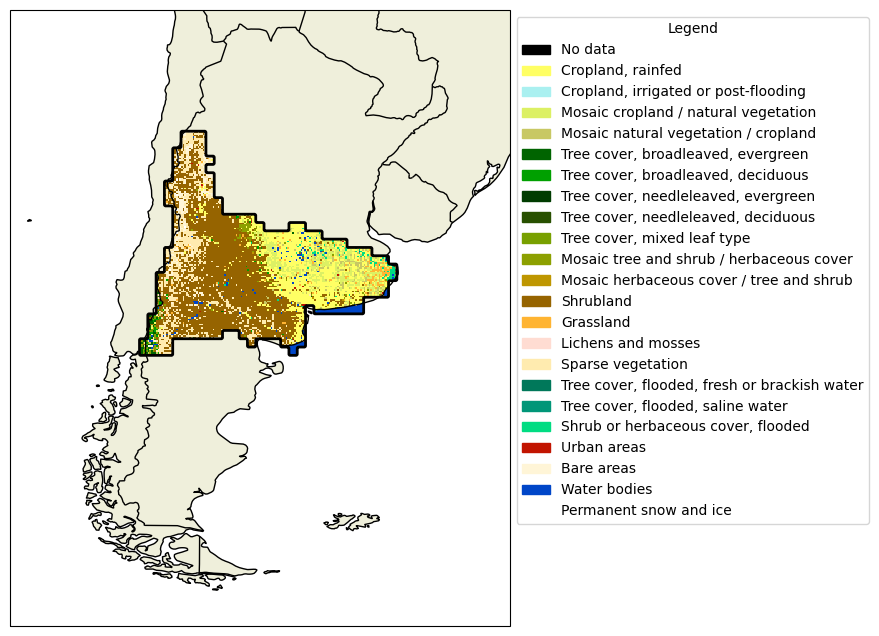

In [69]:
landcover_ARG = plot_landcover("ARG")

Find the starting month

In [70]:
EVI_region_ARG_sm, EVI_region_grid_an_MYD_ARG_sm, EVI_region_grid_an_nd_ARG_sm, spei_region_ARG_sm, SPEI_region_grid_MYD_ARG_sm, SPEI_region_grid_nd_ARG_sm = MYD_EVI_starting_month("ARG")

[ 9 10 11 12] Cropland, rainfed
[19 20] Cropland, irrigated
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] Tree cover, broadleaved
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] Tree cover, needleleaved
[119 120 121 122] Shrubland
[129 130] Grassland
[189 190] Urban areas


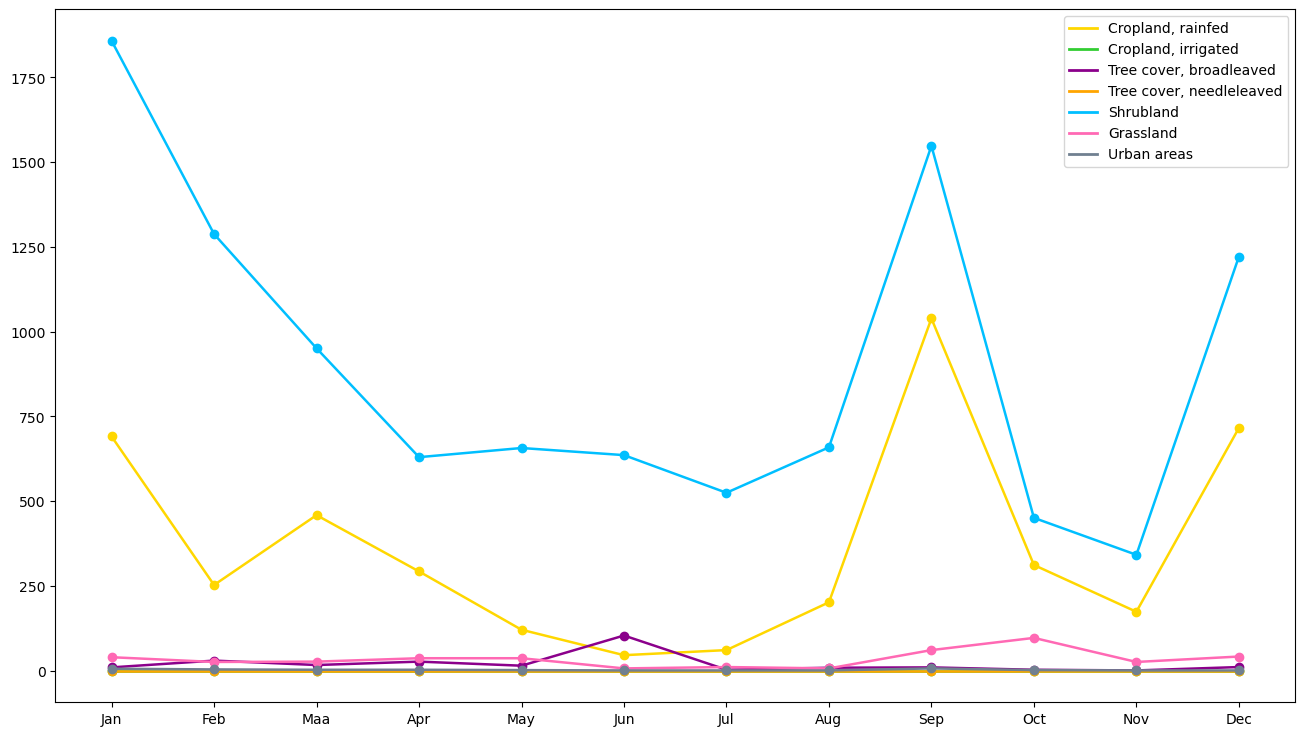

In [71]:
starting_month_plot(EVI_region_grid_an_MYD_ARG_sm, landcover_ARG)

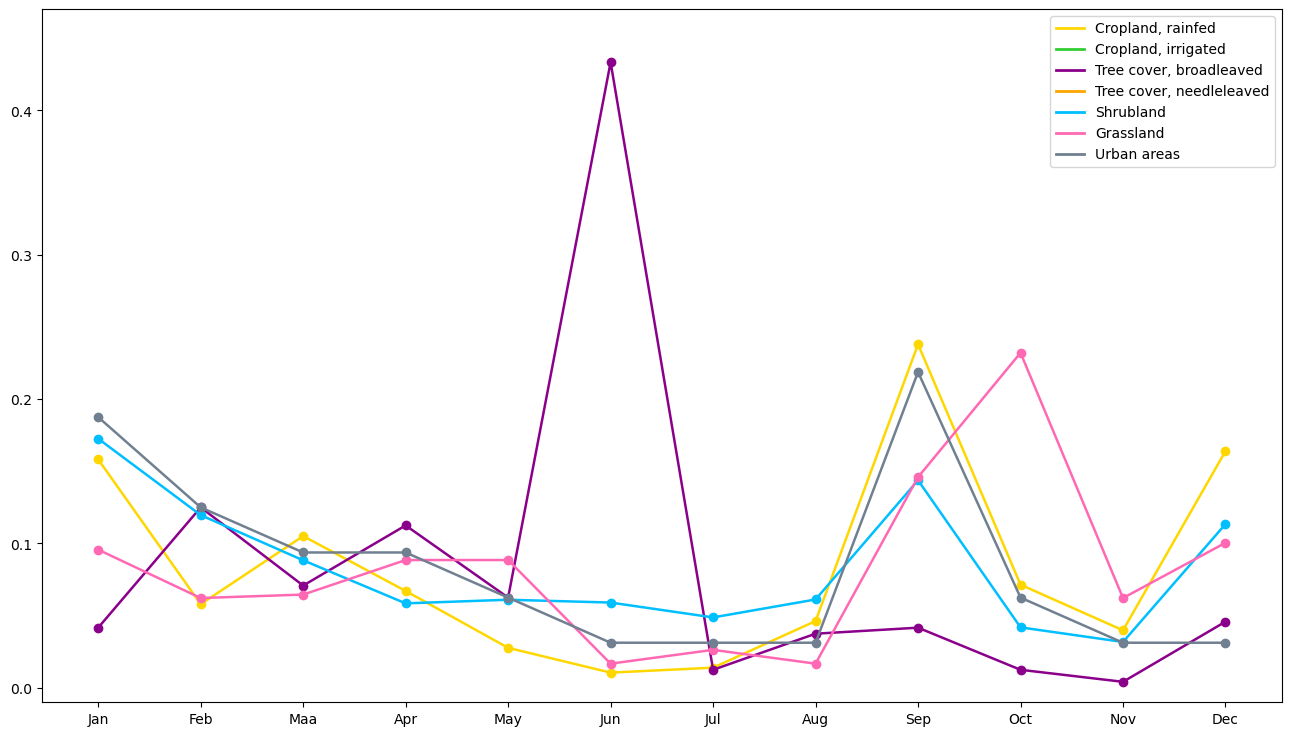

In [72]:
starting_month_plot_normalized(EVI_region_grid_an_MYD_ARG_sm, landcover_ARG)

Most droughts start in september, so i'll take aug, sep, oct.

In [73]:
EVI_region_ARG0, EVI_region_grid_an_MYD_ARG0, EVI_region_grid_an_nd_ARG0, spei_region_ARG0, SPEI_region_grid_MYD_ARG0, SPEI_region_grid_nd_ARG0 = MYD_EVI_yearbefore_first_second("ARG", 11, 0)

In [74]:
EVI_region_ARG1, EVI_region_grid_an_MYD_ARG1, EVI_region_grid_an_nd_ARG1, spei_region_ARG1, SPEI_region_grid_MYD_ARG1, SPEI_region_grid_nd_ARG1 = MYD_EVI_yearbefore_first_second("ARG", 11, 1)

In [75]:
EVI_region_ARG2, EVI_region_grid_an_MYD_ARG2, EVI_region_grid_an_nd_ARG2, spei_region_ARG2, SPEI_region_grid_MYD_ARG2, SPEI_region_grid_nd_ARG2 = MYD_EVI_yearbefore_first_second("ARG", 11, 2)

In [76]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_ARG2, landcover_ARG, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 35169 (24.26% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 936 (0.65% of total)
needleleaved: 0 (0.00% of total)
shrubland: 105885 (73.04% of total)
grassland: 2553 (1.76% of total)
urban: 419 (0.29% of total)


In [77]:
EVI_region_grid_an_MYD_ARG0_filtered = filter_starting_month(EVI_region_grid_an_MYD_ARG0, [8,9,10])
EVI_region_grid_an_MYD_ARG1_filtered = filter_starting_month(EVI_region_grid_an_MYD_ARG1, [8,9,10])
EVI_region_grid_an_MYD_ARG2_filtered = filter_starting_month(EVI_region_grid_an_MYD_ARG2, [8,9,10])

In [78]:
landcover_types = {
    'cropland_rainfed': (np.arange(9, 13), '#FFD700'),
    'cropland_irrigated': (np.arange(19, 21), '#32CD32'),
    'broadleaved': (np.arange(49, 63), '#8B008B'),
    'needleleaved': (np.arange(69, 83), '#FFA500'),
    'shrubland': (np.arange(119, 123), '#00BFFF'),
    'grassland': (np.arange(129, 131), '#FF69B4'),
    'urban': (np.arange(189, 191), '#708090')
}

# Get counts of grid cells for each landcover type
counts = count_grid_cells_by_landcover(EVI_region_grid_an_MYD_ARG2_filtered, landcover_ARG, landcover_types)
# Calculate the total number of grid cells
total_grid_cells = sum(counts.values())
print("Number of grid cells for each landcover in the second drought year:")
for landcover, count in counts.items():
    percent_of_total = (count / total_grid_cells) * 100
    print(f"{landcover}: {count} ({percent_of_total:.2f}% of total)")


Number of grid cells for each landcover in the second drought year:
cropland_rainfed: 14459 (22.54% of total)
cropland_irrigated: 0 (0.00% of total)
broadleaved: 311 (0.48% of total)
needleleaved: 0 (0.00% of total)
shrubland: 47951 (74.75% of total)
grassland: 1221 (1.90% of total)
urban: 204 (0.32% of total)


No needleleaved or irrigated croplands cells, and not that many broadleaved gridcells, look at what they do to decide if we want to include them. Broadleaved acts very weird, don't include it. 

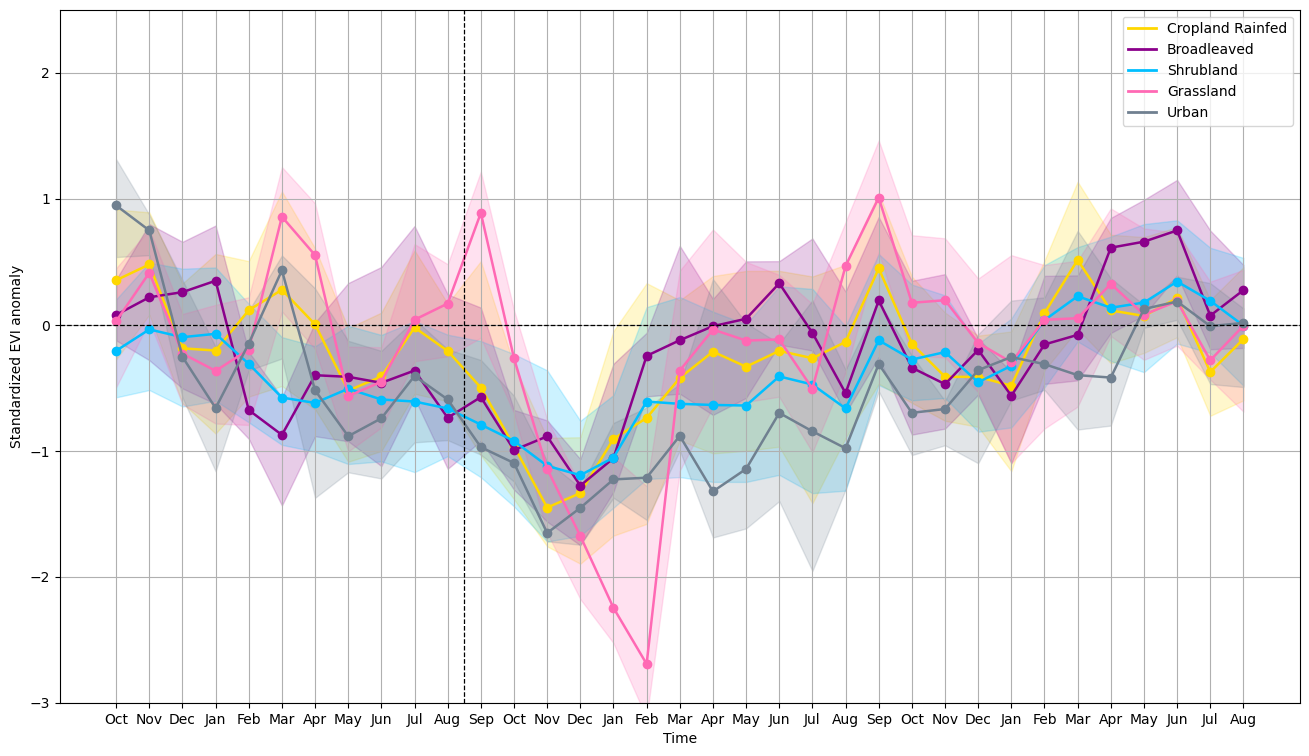

In [80]:
region_name = "ARG"
suptitle = ""
ymin = -3
ymax = 2.5
ylabel = "Standardized EVI anomaly"
shade = True

EVI_region_lc_MYDs0 = EVI_region_grid_an_MYD_ARG0_filtered
EVI_region_lc_MYDs1 = EVI_region_grid_an_MYD_ARG1_filtered
EVI_region_lc_MYDs2 =  EVI_region_grid_an_MYD_ARG2_filtered
starting_month = 9
landcover = landcover_ARG
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban']
savefig = False

mean_data_standardized = line_moreyears_some(region_name, suptitle, EVI_region_lc_MYDs0, EVI_region_lc_MYDs1, EVI_region_lc_MYDs2, starting_month, landcover, included_landcovers, ymin, ymax, ylabel,shade, savefig)

## One figure with ARG, SA and BRA

0
ARG
1
SA
2
BRA


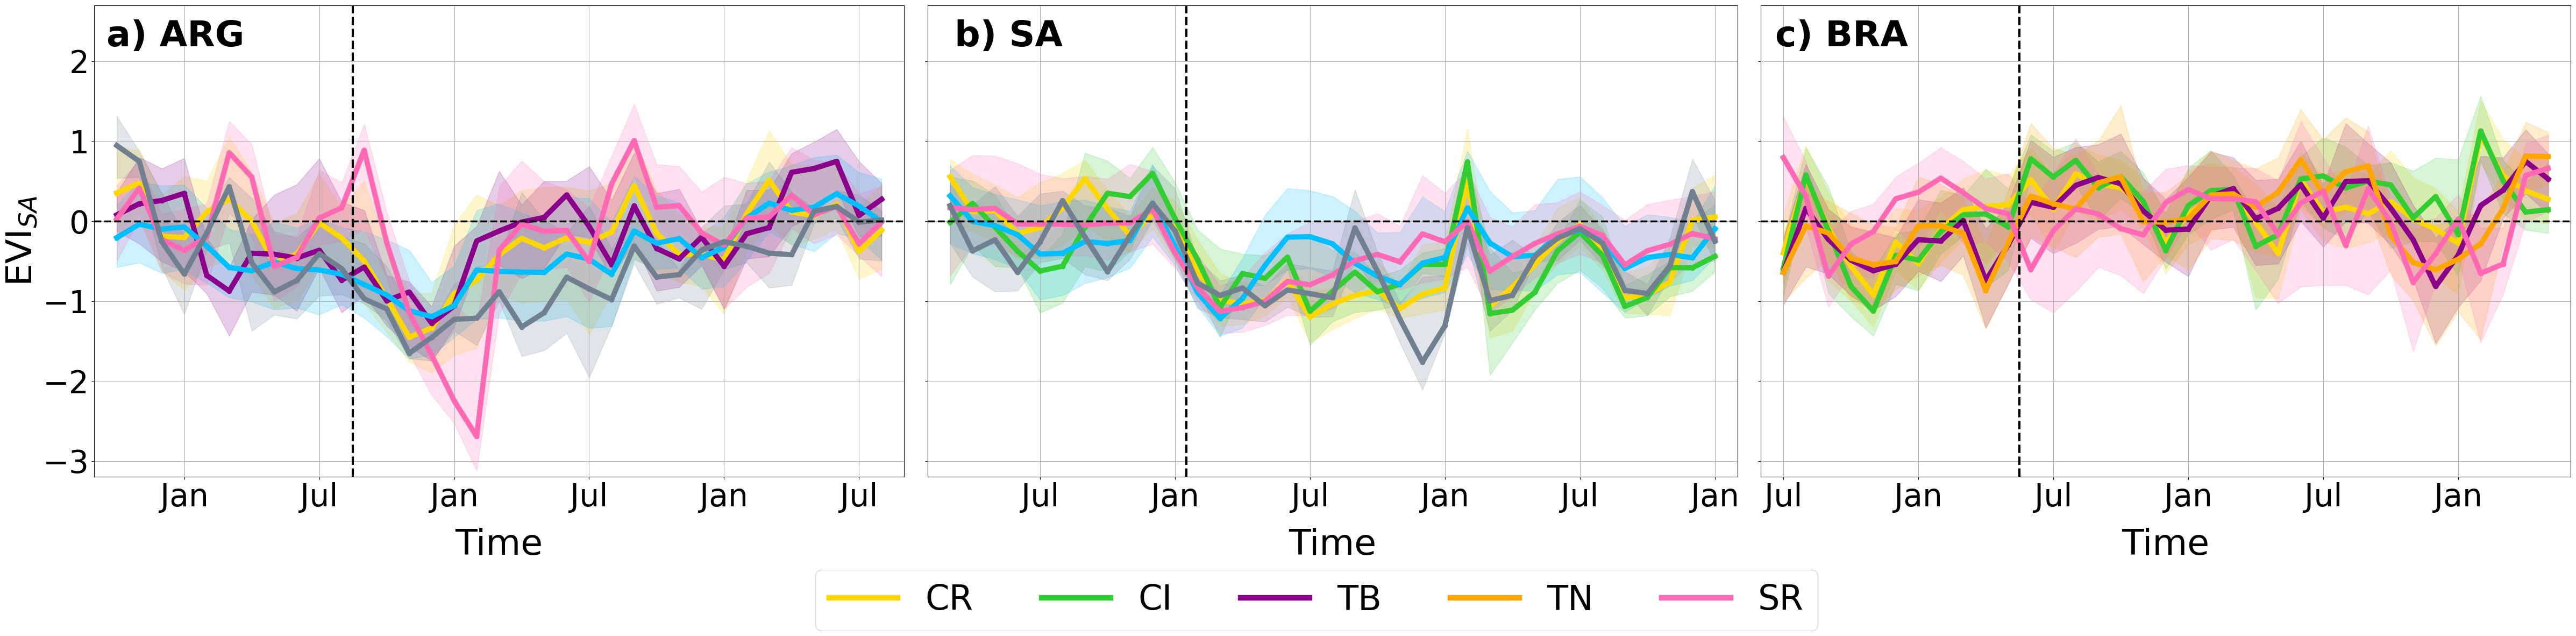

In [81]:
EVI_region_lc_MYDs_list = [
    (EVI_region_grid_an_MYD_ARG0_filtered, EVI_region_grid_an_MYD_ARG1_filtered, EVI_region_grid_an_MYD_ARG2_filtered),
    (EVI_region_grid_an_MYD_SA0_filtered, EVI_region_grid_an_MYD_SA1_filtered, EVI_region_grid_an_MYD_SA2_filtered),
    (EVI_region_grid_an_MYD_BAH0_filtered, EVI_region_grid_an_MYD_BAH1_filtered, EVI_region_grid_an_MYD_BAH2_filtered)
]

region_names = ["ARG","SA","BRA"]
suptitle = ""
ymin = -3.2
ymax = 2.7
ylabel = r"EVI$_{SA}$"
shade = True
starting_month = [9,2,6]
landcover = [landcover_ARG,landcover_SA,landcover_BAH]
included_landcovers = ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'shrubland', 'grassland', 'urban'], ['cropland_rainfed','cropland_irrigated', 'needleleaved', 'shrubland', 'grassland', 'urban'], ['cropland_rainfed','cropland_irrigated', 'broadleaved', 'needleleaved', 'grassland']
savefig = True
line_moreyears_some_one_figure(region_names=region_names, suptitle=suptitle, EVI_region_lc_MYDs_list=EVI_region_lc_MYDs_list, starting_months=starting_month, landcovers=landcover, included_landcovers_list=included_landcovers, ymin=ymin, ymax=ymax, ylabel=ylabel, shade=shade, savefig=savefig)
